In [1]:
import os
import datetime
import numpy as np
from tqdm import tqdm
from matplotlib import patches
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from explore.env.mujoco_sim import MjSim
from explore.utils.vis import AdjMap, play_path
from explore.datasets.utils import cost_computation, load_trees, build_path, generate_adj_map, get_feasible_paths

dataset = "../outputs/2026-02-17/19-35-51"
# dataset = "../multirun/2026-01-31/16-48-06/141"
# dataset = "../multirun/2026-02-03/16-57-58/0"
# dataset = "../data/pandasTable_exp"

config_path = os.path.join(dataset, ".hydra/config.yaml")
cfg = OmegaConf.load(config_path)

ERROR_THRESH = cfg.RRT.min_cost
path_diff_thresh = cfg.RRT.path_diff_thresh
cost_max_method = False

look_at_specific_start_idx = cfg.RRT.start_idx
look_at_specific_end_idx = cfg.RRT.end_idx
cfg.RRT.start_idx = 0
look_at_specific_end_idx = -1
# cutoff = 2500
cutoff = -1

q_mask = np.array(cfg.RRT.q_mask)
sim_cfg = cfg.RRT.sim

mujoco_xml = os.path.join("..", sim_cfg.mujoco_xml)

print(f"Looking at start_idx {look_at_specific_start_idx} and end_idx {look_at_specific_end_idx} with error threshold {ERROR_THRESH}.")
print(f"Tau action: {cfg.RRT.sim.tau_action}; Tau sim: {cfg.RRT.sim.tau_sim}")

Looking at start_idx 1 and end_idx -1 with error threshold 0.05.
Tau action: 0.25; Tau sim: 0.005


## Load data

In [2]:
tree_dataset = os.path.join(dataset, "trees")
trees, tree_count, total_nodes_count = load_trees(tree_dataset, cutoff, verbose=1)

if not q_mask.shape[0]:
    q_mask = np.ones_like(trees[0][0]["state"][1])

print("Loaded ", total_nodes_count, " RRT nodes.")

time_taken = float(np.loadtxt(os.path.join(dataset, "time_taken.txt")))
print(f"Time taken to generate tree: {datetime.timedelta(seconds=time_taken)}")

Tree Count: 100
Loaded  16589  RRT nodes.
Time taken to generate tree: 0:10:01.447923


## Cost evolution over nodes

16490it [00:09, 1820.19it/s]


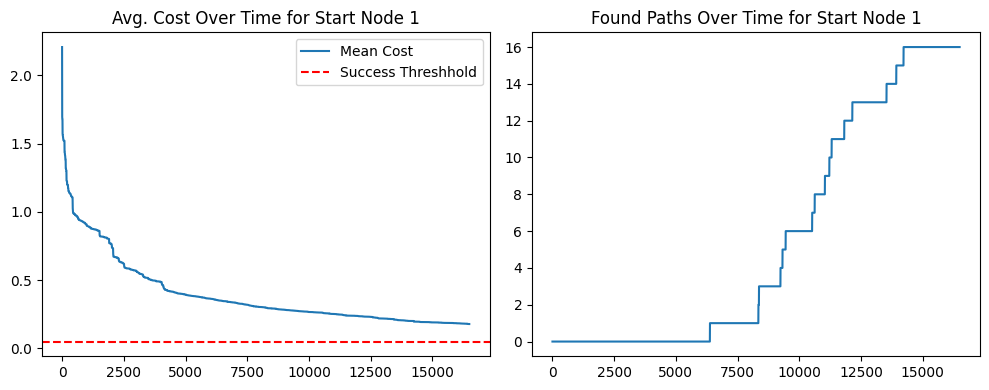

In [3]:
si = 1 if look_at_specific_start_idx == -1 else look_at_specific_start_idx

costs_over_time = []
for i, node in tqdm(enumerate(trees[si])):

    costs = []
    
    for target_idx in range(tree_count):
        cost = cost_computation(trees[target_idx][0], node, q_mask, cost_max_method)
        if i == 0 or costs_over_time[i-1][target_idx] > cost:
            costs.append(cost)
        else:
            costs.append(costs_over_time[i-1][target_idx])

    costs_over_time.append(costs)

# Subtract 1 because it also contains a cost against itself
mean_cost_over_time = [sum(costs)/(len(costs)-1) for costs in costs_over_time]
found_paths_over_time = [len([1 for c in costs if c < ERROR_THRESH])-1 for costs in costs_over_time]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title(f"Avg. Cost Over Time for Start Node {si}")
axes[0].plot(mean_cost_over_time, label="Mean Cost")

if cfg.RRT.end_idx != -1:
    cost_for_target_over_time = [costs[cfg.RRT.end_idx] for costs in costs_over_time]
    axes[0].plot(cost_for_target_over_time, label=f"Target {cfg.RRT.end_idx}")

axes[0].axhline(y=ERROR_THRESH, color="red", linestyle="--", label="Success Threshhold")
axes[0].legend()

axes[1].set_title(f"Found Paths Over Time for Start Node {si}")
axes[1].plot(found_paths_over_time)

plt.tight_layout()
plt.show()

## Expansion Analysis

In [46]:
si = 1 if look_at_specific_start_idx == -1 else look_at_specific_start_idx

sum_grand_children = [0 for _ in trees[si]]
children_count = [0 for _ in trees[si]]
for node in tqdm(trees[si]):
    children_count[node["parent"]] += 1

for i, node in tqdm(enumerate(trees[si])):
    sum_grand_children[node["parent"]] += children_count[i]

avg_grand_children = [sum_grand_children[i] / children_count[i] if children_count[i] != 0 else 0 for i in range(len(trees[si]))]
indices = sorted(range(len(children_count)), key=lambda i: children_count[i], reverse=True)
children_count.sort(reverse=True)
print(indices)
print(children_count)
print(avg_grand_children)

100%|██████████| 12738/12738 [00:00<00:00, 3888997.26it/s]
12738it [00:00, 2868566.14it/s]

[0, 96, 3083, 3075, 91, 104, 2845, 1868, 1978, 4565, 2457, 4713, 9053, 109, 3565, 4591, 6827, 7751, 92, 7323, 2458, 4628, 5433, 81, 2649, 3084, 3947, 8362, 12, 2216, 1775, 3074, 4662, 5605, 11773, 11892, 6, 2690, 8043, 10112, 5, 2830, 6959, 108, 4594, 4881, 5983, 6621, 6821, 2434, 1, 9, 89, 3078, 8102, 10, 27, 38, 46, 66, 67, 74, 78, 85, 95, 113, 114, 122, 129, 140, 150, 151, 170, 177, 259, 295, 306, 324, 365, 393, 394, 414, 425, 428, 470, 516, 552, 553, 586, 588, 611, 736, 781, 806, 877, 894, 898, 918, 933, 968, 1038, 1062, 1166, 1186, 1194, 1220, 1232, 1255, 1281, 1295, 1300, 1308, 1330, 1396, 1397, 1422, 1443, 1493, 1499, 1549, 1555, 1587, 1590, 1602, 1610, 1640, 1668, 1684, 1724, 1752, 1784, 1785, 1796, 1797, 1817, 1844, 1845, 1904, 1925, 1936, 1939, 1979, 1990, 2025, 2041, 2120, 2133, 2154, 2168, 2187, 2236, 2244, 2248, 2256, 2302, 2318, 2341, 2353, 2418, 2428, 2492, 2498, 2546, 2586, 2604, 2696, 2748, 2761, 2796, 2804, 2832, 2838, 2858, 2880, 2949, 3013, 3037, 3050, 3095, 3128, 3

## Costs for all config pairs (without clustering)

Generating Adjacency Map...


100%|██████████| 100/100 [00:02<00:00, 47.22it/s]


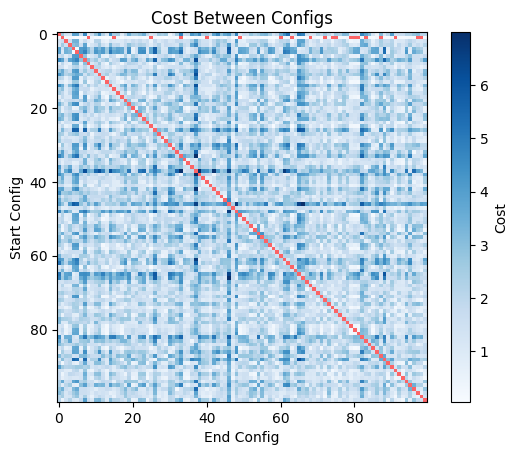

Min cost for all:  0.007517426764070538
Start config: 1
End config:  49


In [47]:
min_costs, top_nodes = generate_adj_map(trees, q_mask, cost_max_method=cost_max_method)
min_costs = np.array(min_costs)

AdjMap(min_costs, ERROR_THRESH, min_costs.max())

min_costs_copy = min_costs.copy()
np.fill_diagonal(min_costs_copy, np.inf)
min_index = np.unravel_index(np.argmin(min_costs_copy), min_costs_copy.shape)
min_cost = min_costs_copy[min_index]

print("Min cost for all: ", min_cost)
print("Start config:", int(min_index[0]))
print("End config: ", int(min_index[1]))

del min_costs_copy

## Found paths count

In [48]:
path_counts = []
end_nodes = []

for i in tqdm(range(tree_count)):

    tree_path_count = [0 for _ in range(tree_count)]
    tree_end_nodes = [[] for _ in range(tree_count)]
    
    for n, node in enumerate(trees[i]):
        for j in range(tree_count):
            node_cost = cost_computation(trees[j][0], node, q_mask, cost_max_method)
            if i != j and node_cost < ERROR_THRESH:
                tree_path_count[j] += 1
                tree_end_nodes[j].append(n)
    
    path_counts.append(tree_path_count)
    end_nodes.append(tree_end_nodes)

path_counts = np.array(path_counts)

100%|██████████| 100/100 [00:02<00:00, 42.04it/s]


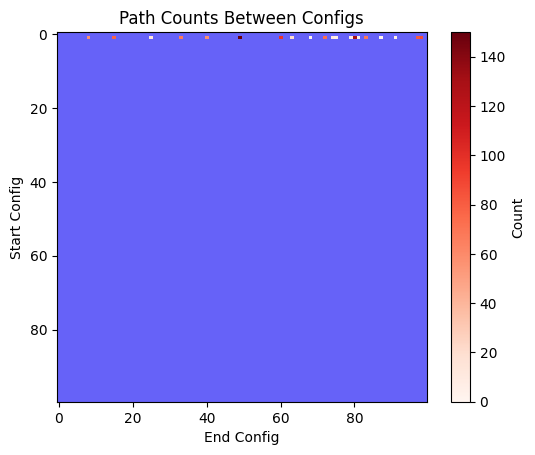

Raw max path found count: 150, mean: 0.1023, std: 3.022819000535758


In [49]:
fig, ax = plt.subplots()

im = ax.imshow(path_counts, cmap="Reds", interpolation="nearest", vmin=0, vmax=path_counts.max())

green_cmap = ListedColormap(["blue"])
overlay = ax.imshow(np.full_like(path_counts, np.nan), cmap=green_cmap, interpolation="nearest", alpha=0.6)
im.set_data(path_counts)
mask = path_counts == 0
overlay.set_data(np.where(mask, 1, np.nan))

plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Path Counts Between Configs")
ax.set_xlabel("End Config")
ax.set_ylabel("Start Config")

plt.show()

print(f"Raw max path found count: {path_counts.max()}, mean: {path_counts.mean()}, std: {path_counts.std()}")

## Measuring Diversity in Found Paths

In [50]:
path_diffs_all = []
full_paths = [[[] for _ in range(tree_count)] for _ in range(tree_count)]

for si in tqdm(range(tree_count)):
    for ei in range(tree_count):
        
        if path_counts[si][ei] == 0:
            continue

        # Load paths
        paths = []
        for end_node in end_nodes[si][ei]:
            fp = build_path(trees[si], end_node)
            paths.append(fp)
            
        path_count = len(paths)
        path_diffs = [[-1 for _ in range(path_count)] for _ in range(path_count)]
        full_paths[si][ei] = paths

        for i, path_a in enumerate(paths):
            for j, path_b in enumerate(paths):
                
                if path_diffs[j][i] == -1:
                    
                    path_diffs[i][j] = 0.0
                    longest_route = max(len(path_a), len(path_b))
                    for n in range(longest_route):
                        na = -1 if n >= len(path_a) else n
                        nb = -1 if n >= len(path_b) else n
                        
                        e = (path_a[na]["state"][1] - path_b[nb]["state"][1]) * q_mask
                        path_diffs[i][j] += np.sqrt(e.T @ e)
                    
                    path_diffs[i][j] /= longest_route
    
                else:
                    path_diffs[i][j] = path_diffs[j][i]

        path_diffs = np.array(path_diffs)
        path_diffs_all.append((path_diffs, si, ei))

100%|██████████| 100/100 [00:02<00:00, 46.93it/s]


100%|██████████| 100/100 [00:00<00:00, 460.77it/s]


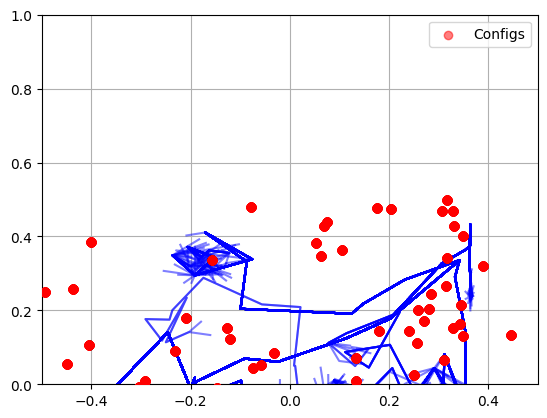

In [51]:
config_poses_x = []
config_poses_y = []

for i in tqdm(range(tree_count)):
    for j in range(tree_count):
        for path in full_paths[i][j]:
            x = [p["state"][1][0] for p in path]
            y = [p["state"][1][1] for p in path]
            plt.plot(x, y, c="blue", alpha=.5)
        
        config_poses_x.append(trees[i][0]["state"][1][0])
        config_poses_y.append(trees[i][0]["state"][1][1])
                

plt.grid(True)
plt.xlim(-0.5, 0.5)
plt.ylim(0.0, 1.0)
plt.scatter(config_poses_x, config_poses_y, c="red", alpha=.5, label="Configs", zorder=3)
plt.legend()

plt.show()

In [34]:
if len(path_diffs_all) and False:
    max_rows = 4
    
    nrows = len(path_diffs_all) if len(path_diffs_all) < max_rows else max_rows
    ncols = int(np.ceil(len(path_diffs_all) / max_rows))

    fig, ax = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    ax = ax.flatten()
    
    for i, (path_diff, si, ei) in enumerate(path_diffs_all):
        im = ax[i].imshow(path_diff, cmap="Greens", interpolation="nearest", vmin=path_diff.min(), vmax=path_diff.max())

        cmap = ListedColormap(["red"])
        overlay = ax[i].imshow(np.full_like(path_diff, np.nan), cmap=cmap, interpolation="nearest", alpha=1.)
        im.set_data(path_diff)
        mask = path_diff < path_diff_thresh
        overlay.set_data(np.where(mask, 1, np.nan))

        # plt.colorbar(im, ax=ax[i], label="Diff")
        ax[i].set_title(f"Start idx {si} and End idx {ei}")
        ax[i].set_xlabel("Path idx")
        ax[i].set_ylabel("Path idx")

    plt.tight_layout()
    plt.savefig("path_similarities")
    pass

In [52]:
path_diffs_mat = [[[] for _ in range(tree_count)] for _ in range(tree_count)]
for pda in path_diffs_all:
    path_diffs_mat[pda[1]][pda[2]] = pda[0]

real_path_counts = []
trees_paths_idxs = []

for i in range(tree_count):

    tree_path_count = [0 for _ in range(tree_count)]
    tree_paths = [[] for _ in range(tree_count)]
    
    for j in range(tree_count):
        
        if i != j:
            path_count = len(path_diffs_mat[i][j])
            for p_a in range(path_count):
                special = True
                for p_b in tree_paths[j]:
                    if path_diffs_mat[i][j][p_a][p_b] < path_diff_thresh:
                        special = False
                        break
                    
                if special:
                    tree_path_count[j] += 1
                    tree_paths[j].append(p_a)
    
    real_path_counts.append(tree_path_count)
    trees_paths_idxs.append(tree_paths)

real_path_counts = np.array(real_path_counts)

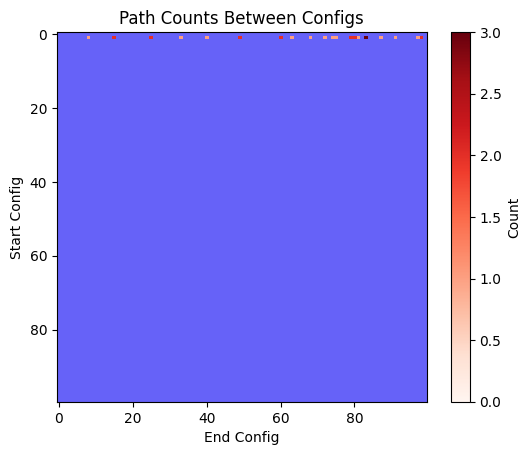

Real max path found count: 3, mean: 0.0029, std: 0.06993990277373854


In [53]:
fig, ax = plt.subplots()

im = ax.imshow(real_path_counts, cmap="Reds", interpolation="nearest", vmin=0, vmax=real_path_counts.max())

green_cmap = ListedColormap(["blue"])
overlay = ax.imshow(np.full_like(real_path_counts, np.nan), cmap=green_cmap, interpolation="nearest", alpha=0.6)
im.set_data(real_path_counts)
mask = real_path_counts == 0
overlay.set_data(np.where(mask, 1, np.nan))

plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Path Counts Between Configs")
ax.set_xlabel("End Config")
ax.set_ylabel("Start Config")

plt.show()

print(f"Real max path found count: {real_path_counts.max()}, mean: {real_path_counts.mean()}, std: {real_path_counts.std()}")

In [55]:
trees_paths_idxs_flatten = []
for i in range(tree_count):
    for j in range(tree_count):
        if i != j and len(trees_paths_idxs[i][j]) > 3:
            trees_paths_idxs_flatten.append((trees_paths_idxs[i][j], i, j))

print(f"Total config pairs with diverse paths: {len(trees_paths_idxs_flatten)}")

# TODO: Use PCA for the analysis?
if len(trees_paths_idxs_flatten) and False:
    max_rows = 2
    
    nrows = len(trees_paths_idxs_flatten) if len(trees_paths_idxs_flatten) < max_rows else max_rows
    ncols = int(np.ceil(len(trees_paths_idxs_flatten) / max_rows))

    fig, ax = plt.subplots(ncols, nrows, figsize=(nrows * 5, ncols * 5))
    ax = ax.flatten()
    
    for i, (path_ids, si, ei) in tqdm(enumerate(trees_paths_idxs_flatten)):
        for j, path_idx in enumerate(path_ids):
            path = full_paths[si][ei][path_idx]
            x = [p["state"][1][0] for p in path]
            y = [p["state"][1][1] for p in path]
            if j == 0:
                ax[i].scatter([x[0]], [y[0]], label="Start", c="red")
                ax[i].scatter([x[-1]], [y[-1]], label="End", c="green")
            else:
                ax[i].scatter([x[0]], [y[0]], c="red")
                ax[i].scatter([x[-1]], [y[-1]], c="green")
                
            if j < 4:
                ax[i].plot(x, y, label=f"Path {j}", alpha=0.5)
            elif j == 4:
                ax[i].plot(x, y, label=f"(Total {len(path_ids)})", alpha=0.5)
        ax[i].legend()
        ax[i].grid(True)
        # ax[i].axis("equal")
        ax[i].set_xlim(-0.5, 0.5)
        ax[i].set_ylim(0.0, 1.0)

    plt.tight_layout()
    plt.show()

Total config pairs with diverse paths: 0


## Clustering

In [56]:
colors = [-1 for _ in range(tree_count)]

max_color_idx = 0
for i in range(tree_count):
        
    if colors[i] == -1:
        colors[i] = max_color_idx
        max_color_idx += 1
        
        for j in range(tree_count):
            if i != j and min_costs[i][j] <= ERROR_THRESH:
                if colors[j] != -1:
                    c = colors[j]
                    for k in range(tree_count):
                        if colors[k] == c:
                            colors[k] = colors[i]
                else:
                    colors[j] = colors[i]

groups = []
for c in colors:
    if not c in groups:
        groups.append(c)

group_sizes = [0 for _ in groups]
for c in colors:
    group_sizes[groups.index(c)] += 1

# print(colors)
# print(groups)
print("Group Count: ", len(groups))
print("Group Sizes: ", group_sizes)

Group Count:  80
Group Sizes:  [1, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Looking at specific start and end configurations

Mean costs for start config 1: 0.14871972739595354, (Min: 0.007517426764070538, Max 0.8290919466346864)


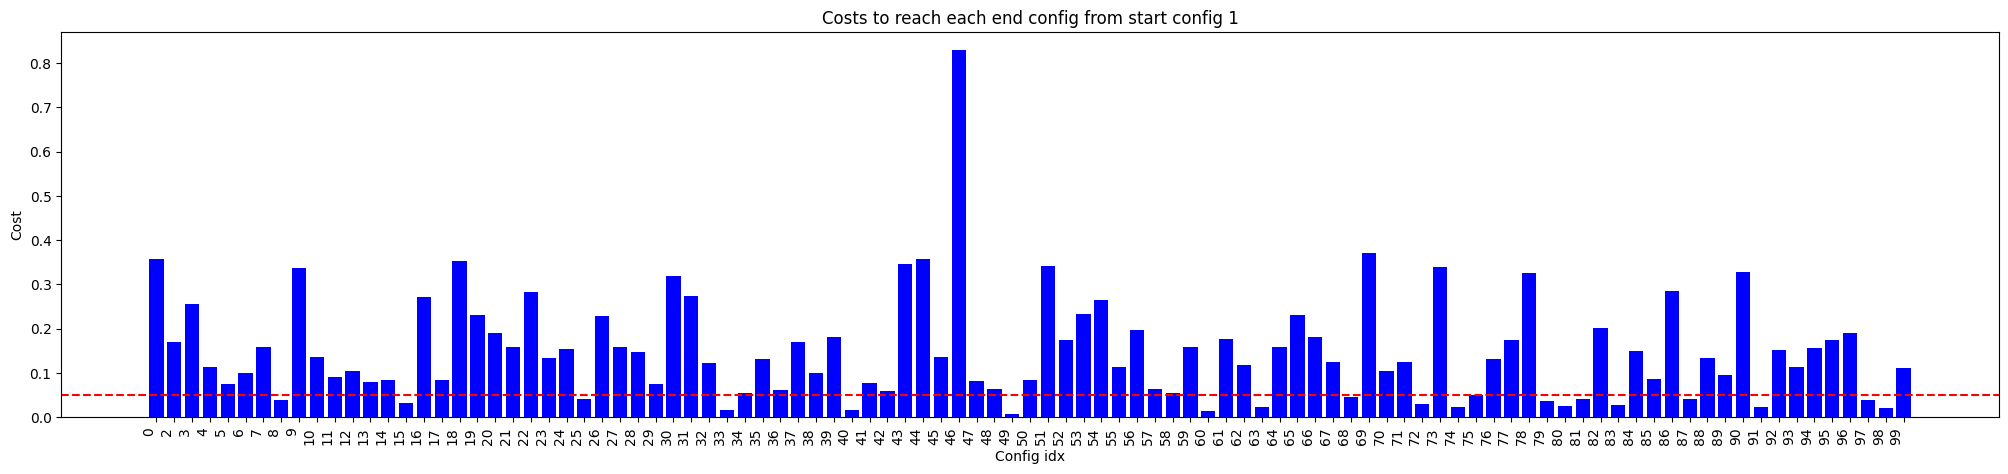

In [57]:
start_idx = look_at_specific_start_idx
end_idx = look_at_specific_end_idx

if look_at_specific_start_idx != -1:
    costs = [min_costs[start_idx][i] for i in range(tree_count) if start_idx != i]
    print(f"Mean costs for start config {start_idx}: {sum(costs)/tree_count}, (Min: {min(costs)}, Max {max(costs)})")
    labels = [str(i) for i in range(tree_count) if i != start_idx]
    
    highlight_labels = {str(end_idx)}
    colors = ["red" if label in highlight_labels else "blue" for label in labels]
    plt.figure(figsize=(25, 5))
    plt.bar(labels, costs, color=colors)
    plt.xticks(rotation=90, ha="right")
    plt.axhline(y=ERROR_THRESH, color="red", linestyle="--")
    plt.title(f"Costs to reach each end config from start config {start_idx}")
    plt.xlabel("Config idx")
    plt.ylabel("Cost")
    plt.show()

    if end_idx != -1:
        print(f"Cost for target {end_idx} with start {start_idx}: {costs[end_idx]}")

## Collecting top paths

In [58]:
traj_pairs, end_nodes, top_costs = get_feasible_paths(
                min_costs, top_nodes, look_at_specific_start_idx, look_at_specific_end_idx, ERROR_THRESH)

top_paths = []
top_paths_start = []
top_paths_goal = []
for i, path_data in enumerate(traj_pairs):

    start_idx = path_data[0]
    end_idx = path_data[1]
    if start_idx == end_idx: continue
    
    tree = trees[start_idx]
    
    path = build_path(tree, end_nodes[i])

    top_paths.append(path)
    top_paths_start.append(start_idx)
    top_paths_goal.append(end_idx)

target_counts = []
for i, path in enumerate(top_paths):
    goal_idx = top_paths_goal[i]
    target_counts.append(0)
    for node in path:
        if goal_idx == node["target_config_idx"]:
            target_counts[-1] += 1

percs = [float(np.round(c/len(top_paths[i])*100)) for i, c in enumerate(target_counts)]
percs.sort()
percs.reverse()

possible_paths = tree_count**2 - tree_count
print("Top costs: ", [float(c) for c in top_costs])
print("Found Trajectories Count: ", len(top_paths), " of ", possible_paths)
if look_at_specific_start_idx == -1:
    print("When considering full graph: ", sum([v**2 for v in group_sizes]) - tree_count, " of ", possible_paths)

if not top_paths:
    print("No trajectories found!")

else:
    print("Percentage of reached config used as target: ", percs)
    print("Avg. use of reached config as target: ", sum(percs)/len(percs))

    path_lens = [len(p) for p in top_paths]

    # print("Path lens: [", end="")
    # for i in range(len(top_paths)):
    #     end = "]\n" if i == len(top_paths)-1 else ", "
    #     print(f"{path_lens[i]} ({top_paths_start[i]}, {top_paths_goal[i]})", end=end)

    path_lens_copy = path_lens.copy()
    path_lens_copy.sort()
    path_lens_copy.reverse()
    print("Path lengths: ", path_lens_copy)
    print("Avg. Path length: ", sum(path_lens_copy)/len(path_lens_copy))

Top costs:  [0.0383441164955566, 0.030998647204087907, 0.04077688179109519, 0.015883040448706975, 0.015645793442911, 0.007517426764070538, 0.012807831396580836, 0.021872691920312486, 0.045764440611274056, 0.029245264171861306, 0.02262797546930252, 0.048866667625169044, 0.036065480031562104, 0.02438246200789371, 0.0399028038650209, 0.02638788096979796, 0.04104711948005383, 0.022176127901412736, 0.038624422073787516, 0.02120403313615193]
Found Trajectories Count:  20  of  9900
Percentage of reached config used as target:  [63.0, 57.0, 56.0, 54.0, 50.0, 48.0, 40.0, 39.0, 36.0, 36.0, 35.0, 35.0, 28.0, 25.0, 25.0, 20.0, 15.0, 11.0, 5.0, 0.0]
Avg. use of reached config as target:  33.9
Path lengths:  [25, 25, 23, 22, 21, 20, 20, 20, 20, 19, 19, 18, 18, 17, 17, 16, 14, 13, 12, 10]
Avg. Path length:  18.45


## Sample a single path

In [59]:
path = []
min_path_len = 10

if not top_paths:
    print("No good paths no analyse!")

else:
    valid_path_idxs = [i for i, l in enumerate(path_lens) if l >= min_path_len]

    # path_idx = top_paths_goal.index(cfg.RRT.end_idx)
    path_idx = np.random.choice(valid_path_idxs)
    path = top_paths[path_idx]
    start_idx = top_paths_start[path_idx]
    end_idx = top_paths_goal[path_idx]
    e_vec = trees[end_idx][0]["state"][1] - path[-1]["state"][1]

    print("---- Sampled Path Data ----")
    print("Target config ids: ", [n["target_config_idx"] for n in path])
    print("Start idx: ", start_idx)
    print("End idx: ", end_idx)
    print("Cost: ", top_costs[path_idx])
    print("Error vec: ", e_vec)
    print("Error vec (with mask): ", e_vec * q_mask)
    print("Sampled Path Length: ", len(path))

---- Sampled Path Data ----
Target config ids:  [-1, np.int64(7), np.int64(38), np.int64(11), np.int64(33), np.int64(38), np.int64(38), np.int64(38), np.int64(33), np.int64(23), np.int64(6), np.int64(49), np.int64(80), np.int64(25), np.int64(91), np.int64(97), np.int64(97), np.int64(97), np.int64(97), np.int64(97), np.int64(97), np.int64(97), np.int64(97), np.int64(97), np.int64(97)]
Start idx:  1
End idx:  97
Cost:  0.038624422073787516
Error vec:  [-4.52632828e-03 -1.94870655e-03  1.76553750e-02 -1.18087075e-04
 -9.70231980e-03  1.26592917e-02 -1.11372548e-02  1.35921063e-02
 -2.88763370e-04 -5.51724616e-02 -5.51726531e-02 -5.39763921e-01
 -5.39762612e-01]
Error vec (with mask):  [-4.52632828e-03 -1.94870655e-03  1.76553750e-02 -1.18087075e-04
 -9.70231980e-03  1.26592917e-02 -2.22745096e-02  2.71842126e-02
 -5.77526740e-04 -1.37931154e-02 -1.37931633e-02 -1.34940980e-01
 -1.34940653e-01]
Sampled Path Length:  25


Playing path with length 25


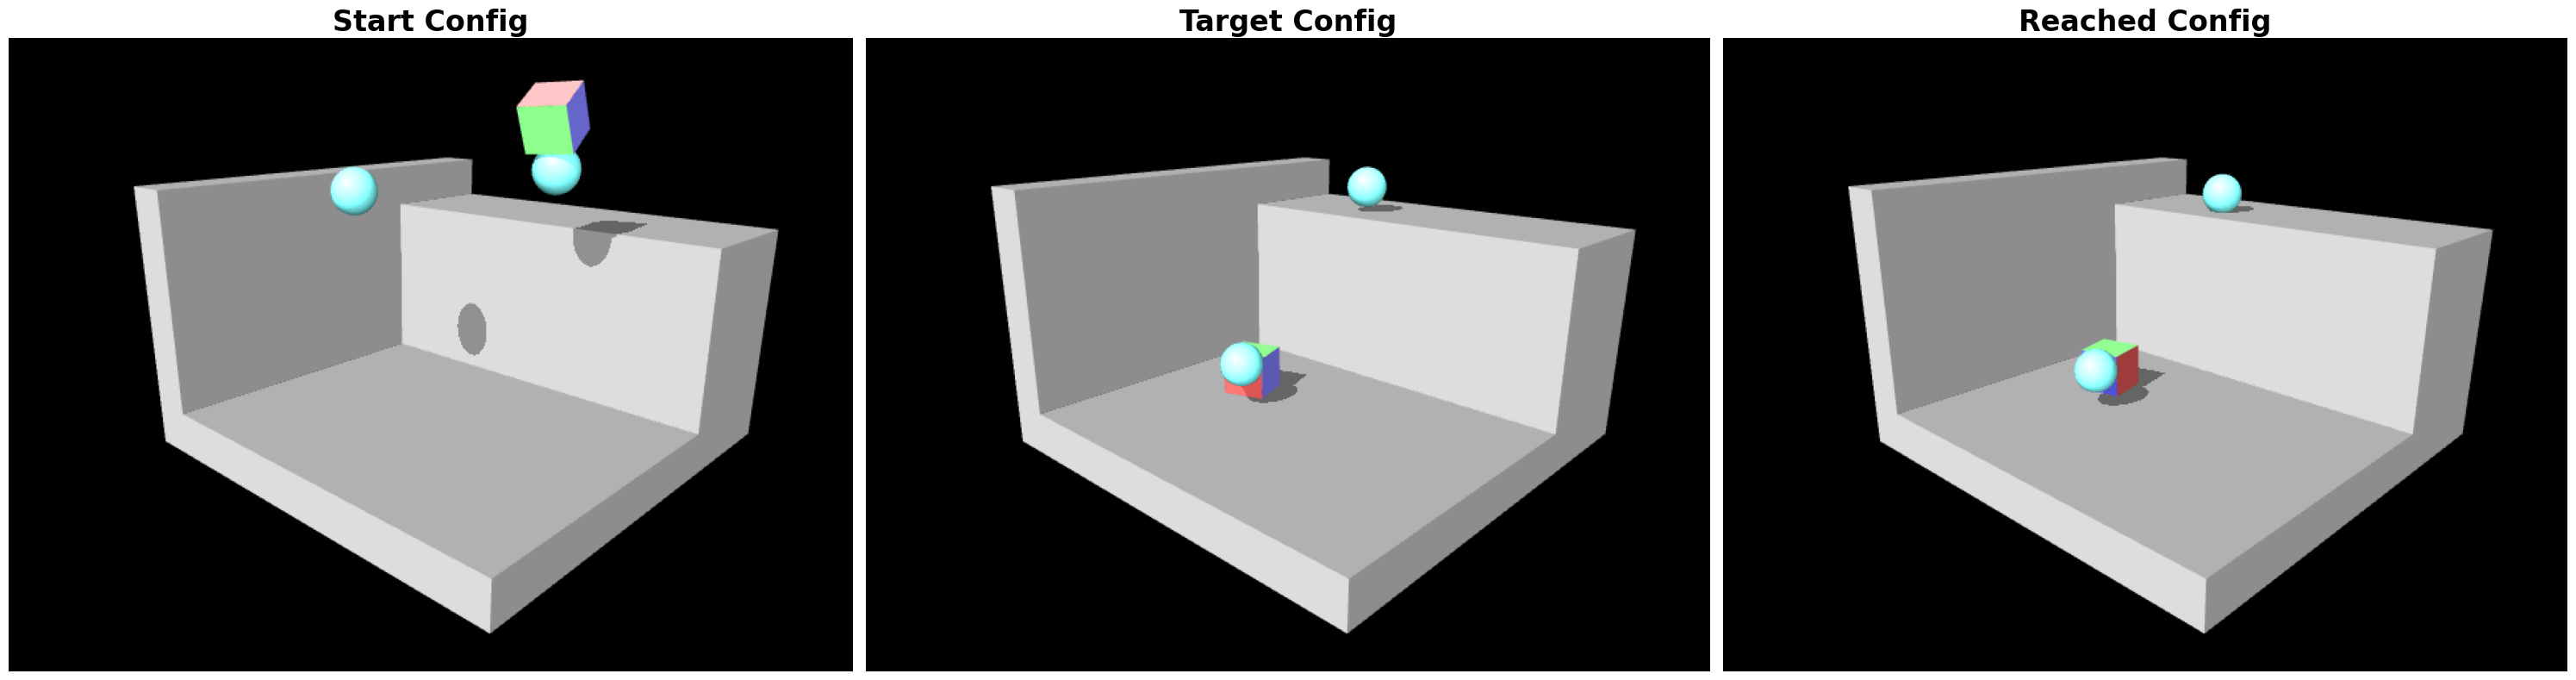

In [60]:
if path:
    start_state = trees[start_idx][0]["state"][1]
    target_state = trees[end_idx][0]["state"][1]
    sim = MjSim(
        mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
        joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False, use_spline_ref=sim_cfg.use_spline_ref
    )
    play_path(path, sim, start_state, target_state, tau_action=sim_cfg.tau_action, camera=cfg.RRT.sim.camera, reset_state=True)

---- Sampled Path Data ----
Target config ids:  [-1, np.int64(52), np.int64(55), np.int64(67), np.int64(52), np.int64(18), np.int64(69), np.int64(93), np.int64(93), np.int64(3), np.int64(13), np.int64(31), np.int64(49), np.int64(88), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8)]
Start idx:  1
End idx:  8
Cost:  0.0383441164955566
Error vec:  [-0.01046441  0.0676871   0.01250257 -0.00123569  0.00098364  0.01444791
  0.00656324 -0.04419217 -0.01456351 -0.19918765  0.2982782  -0.51231832
 -0.01153126]
Error vec (with mask):  [-0.01046441  0.0676871   0.01250257 -0.00123569  0.00098364  0.01444791
  0.01312647 -0.08838434 -0.02912703 -0.04979691  0.07456955 -0.12807958
 -0.00288281]
Sampled Path Length:  23
Playing path with length 23
---- Sampled Path Data ----
Target config ids:  [-1, np.int64(7), np.int64(38), np.int64(11), np.int64(33), np.int64(38), np.int64(38), np.int64(38), np.int64(33), np.int64(64), np.int64(9

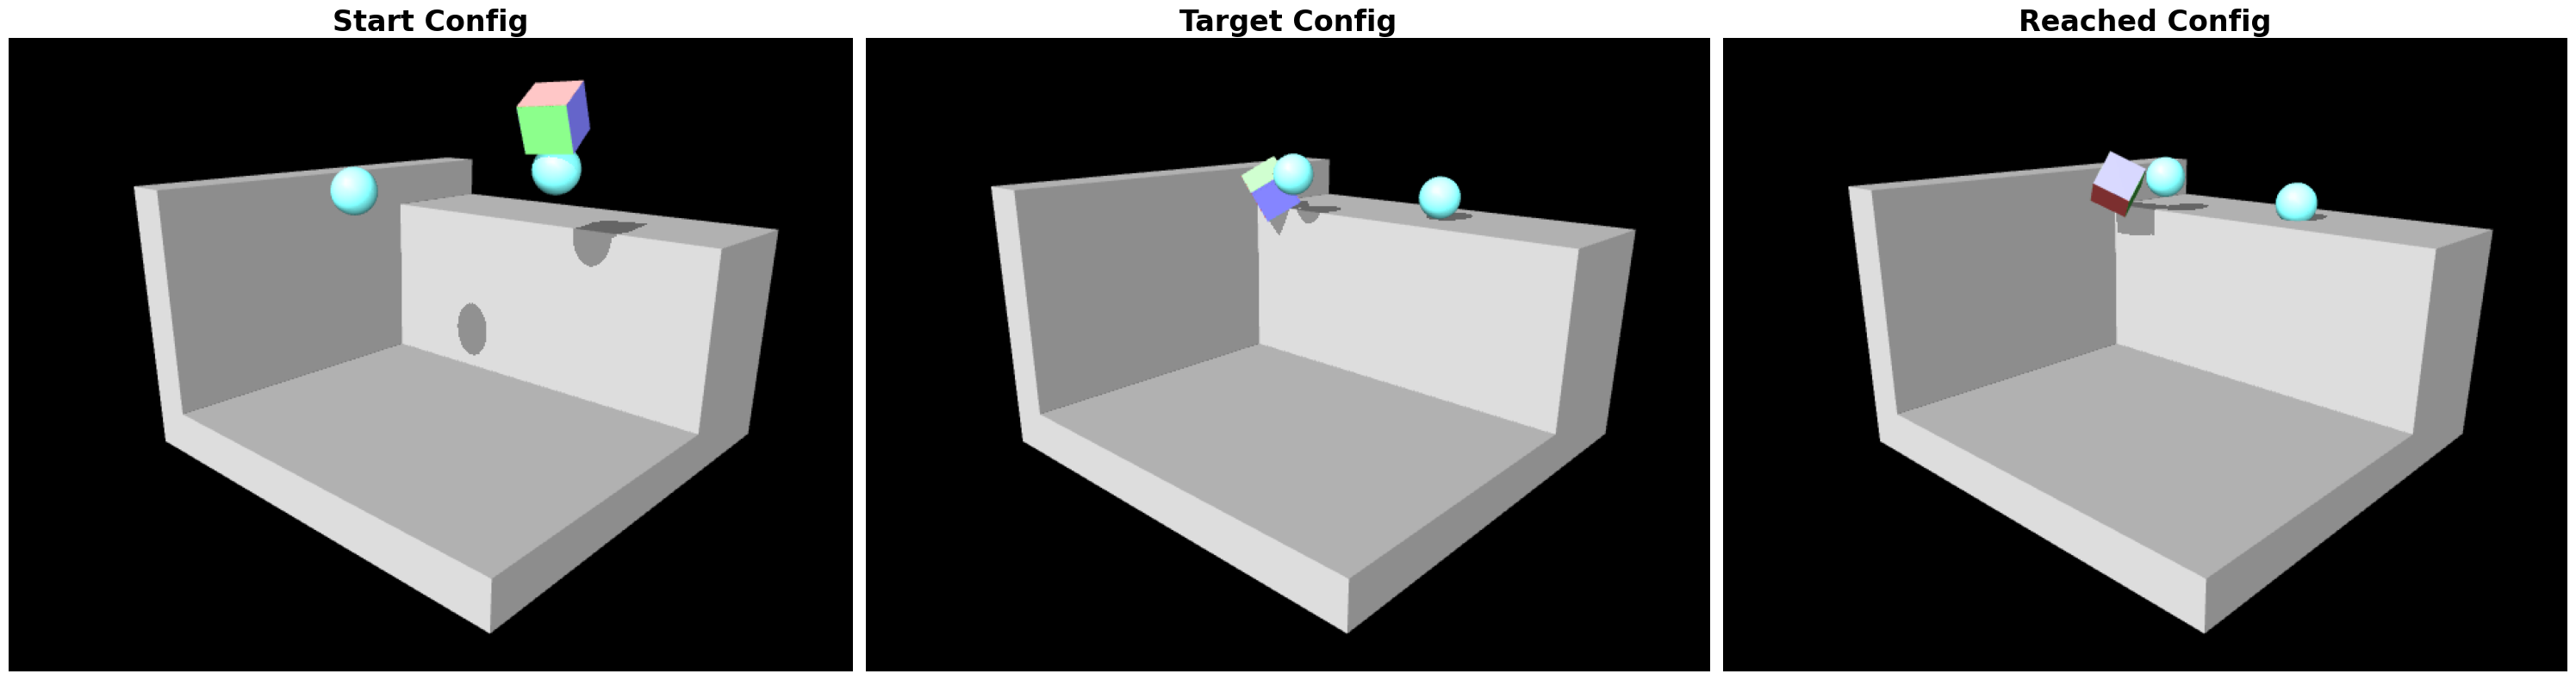

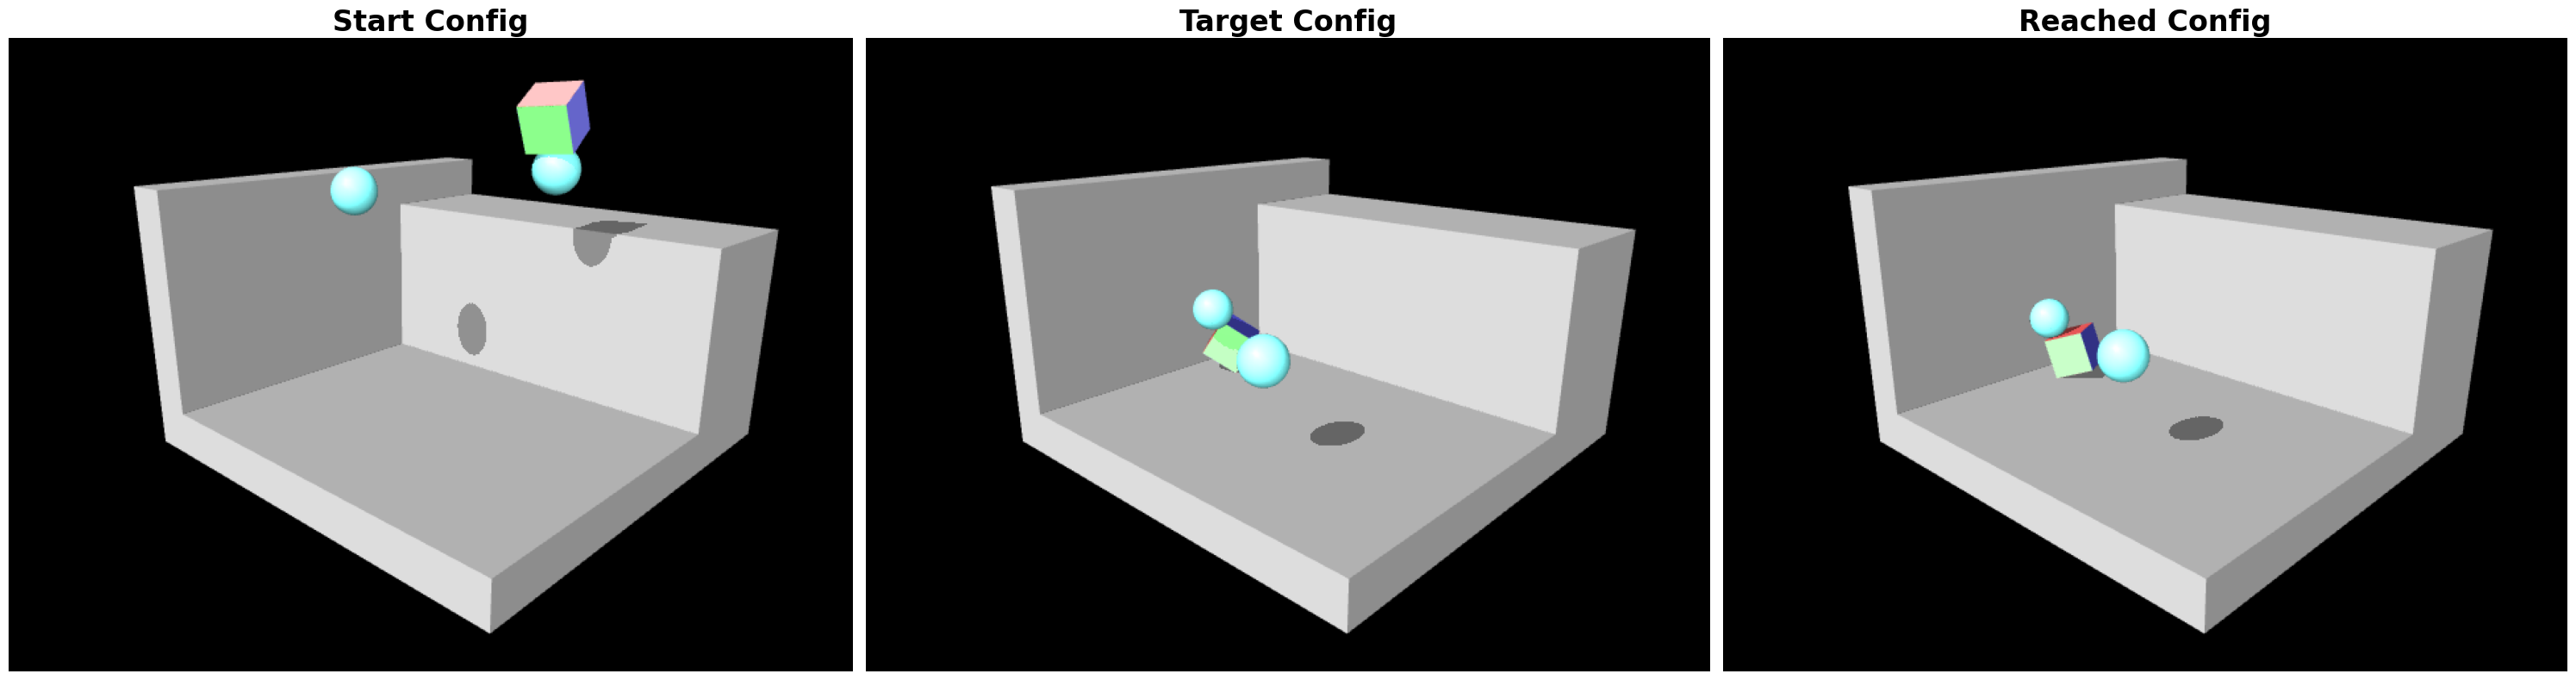

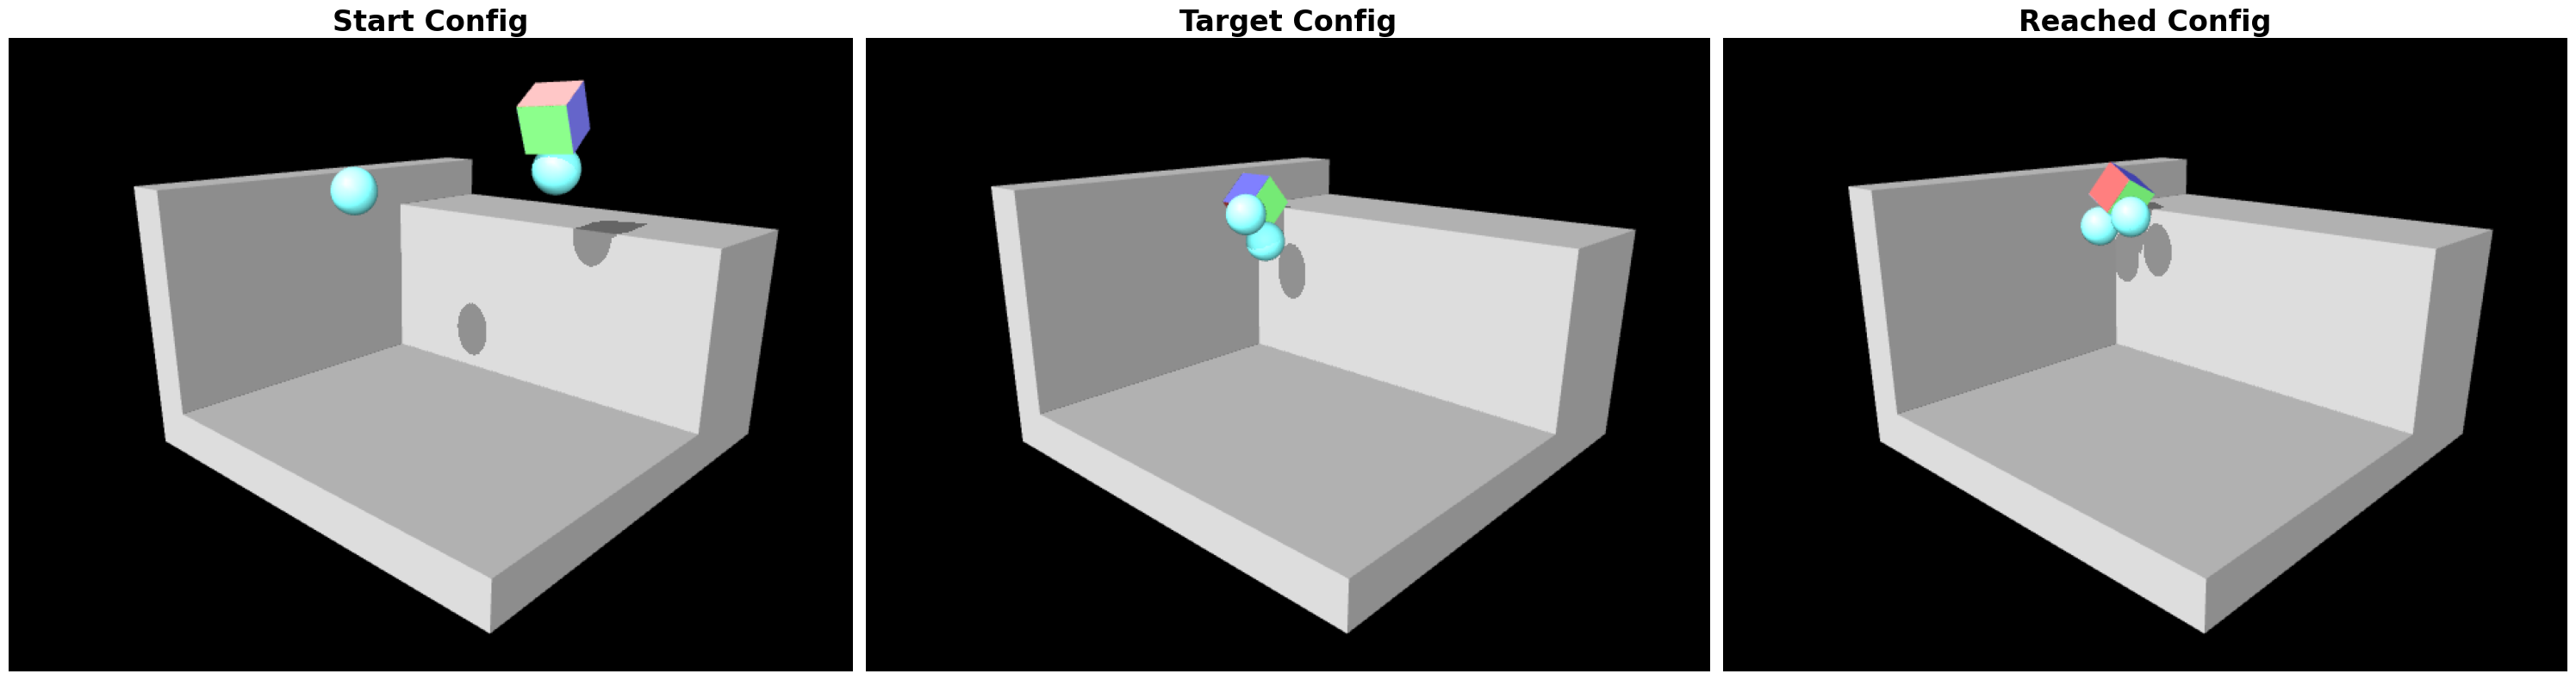

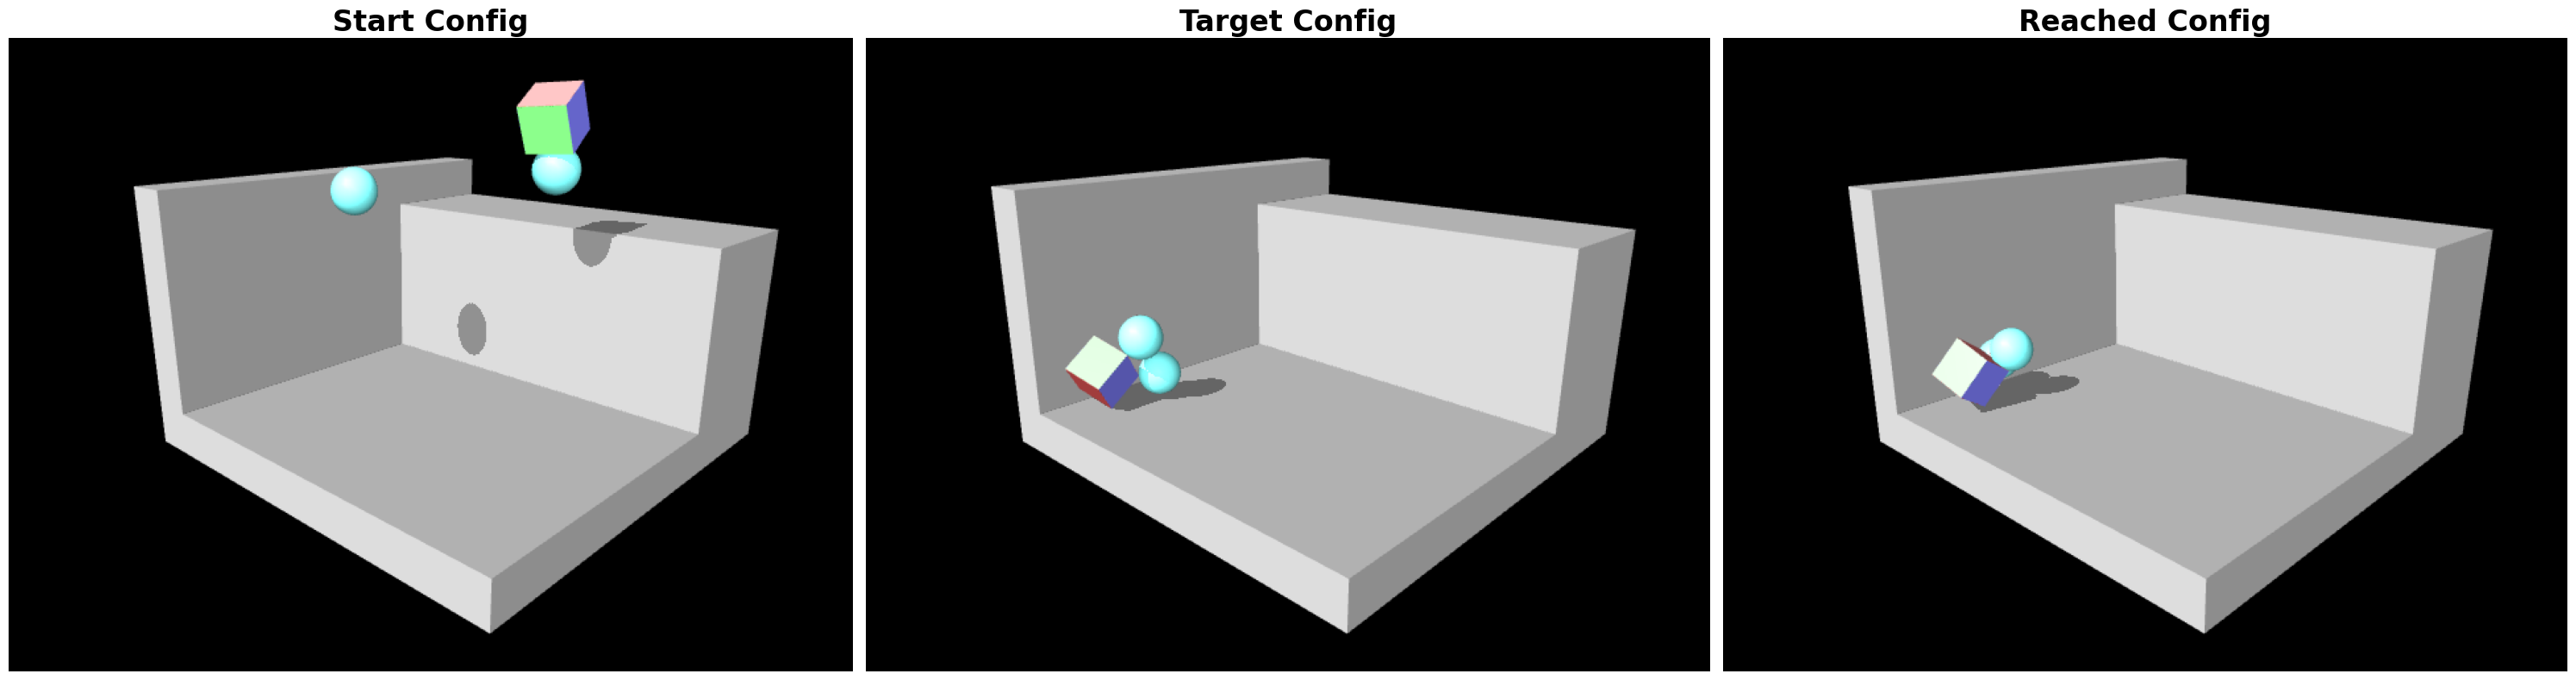

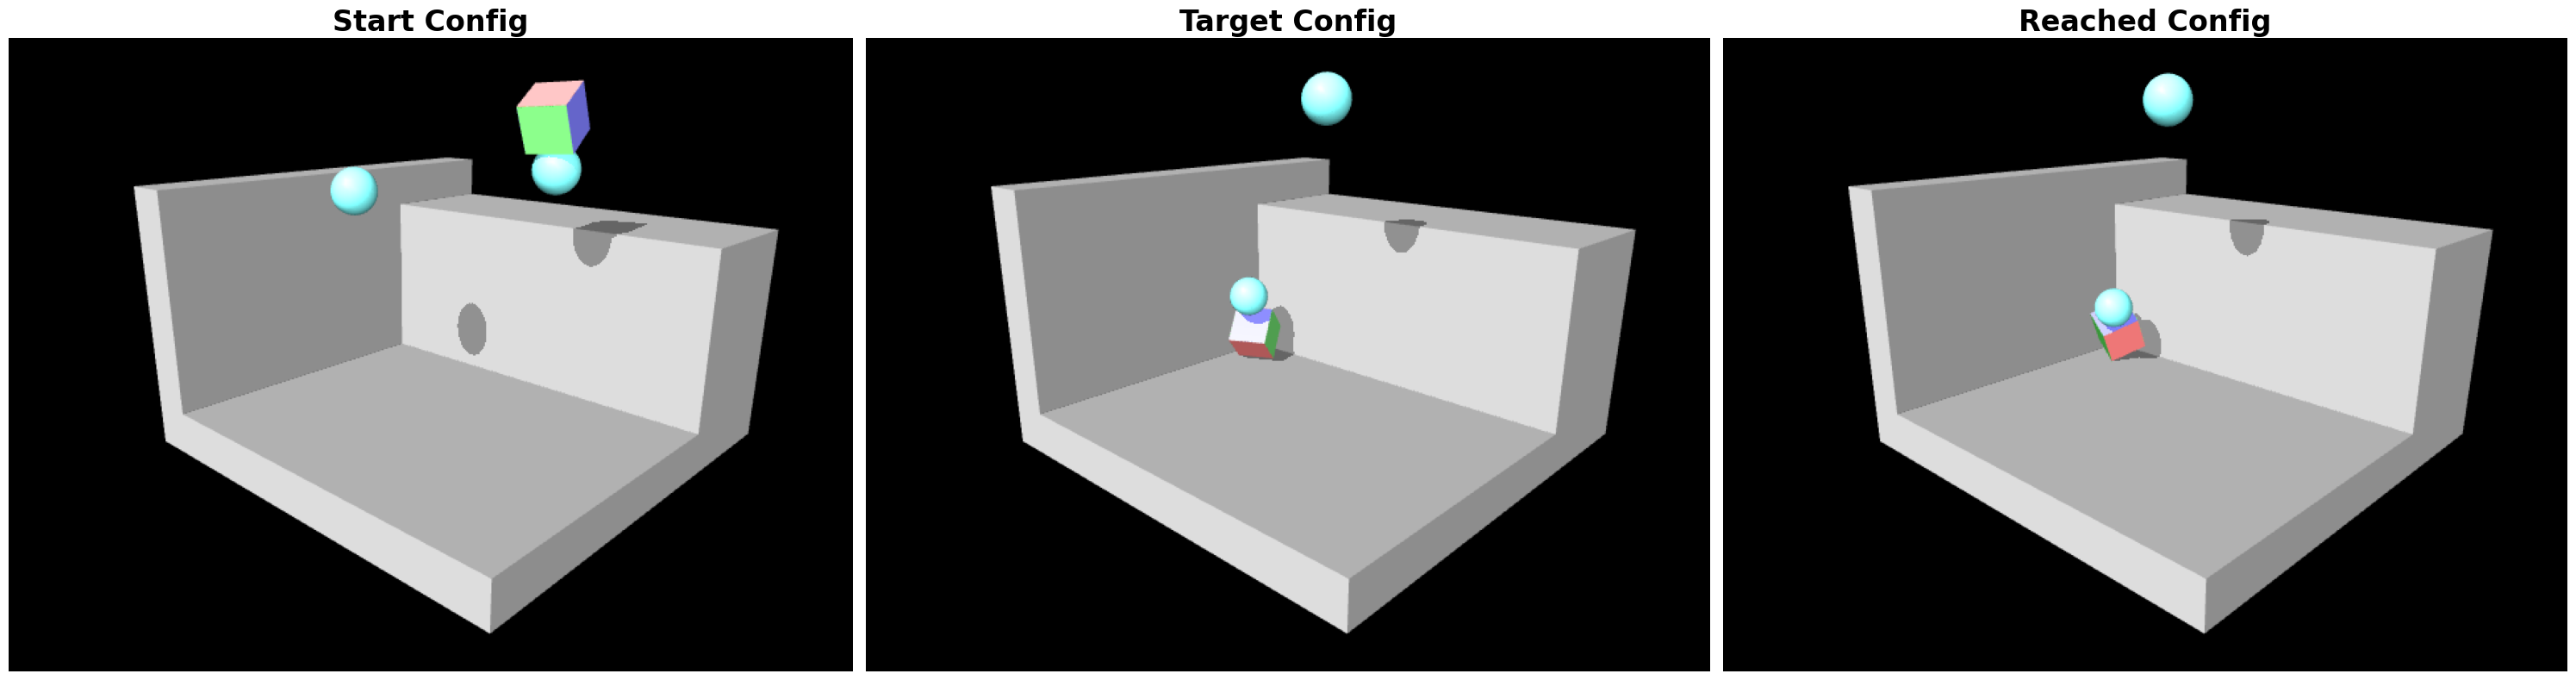

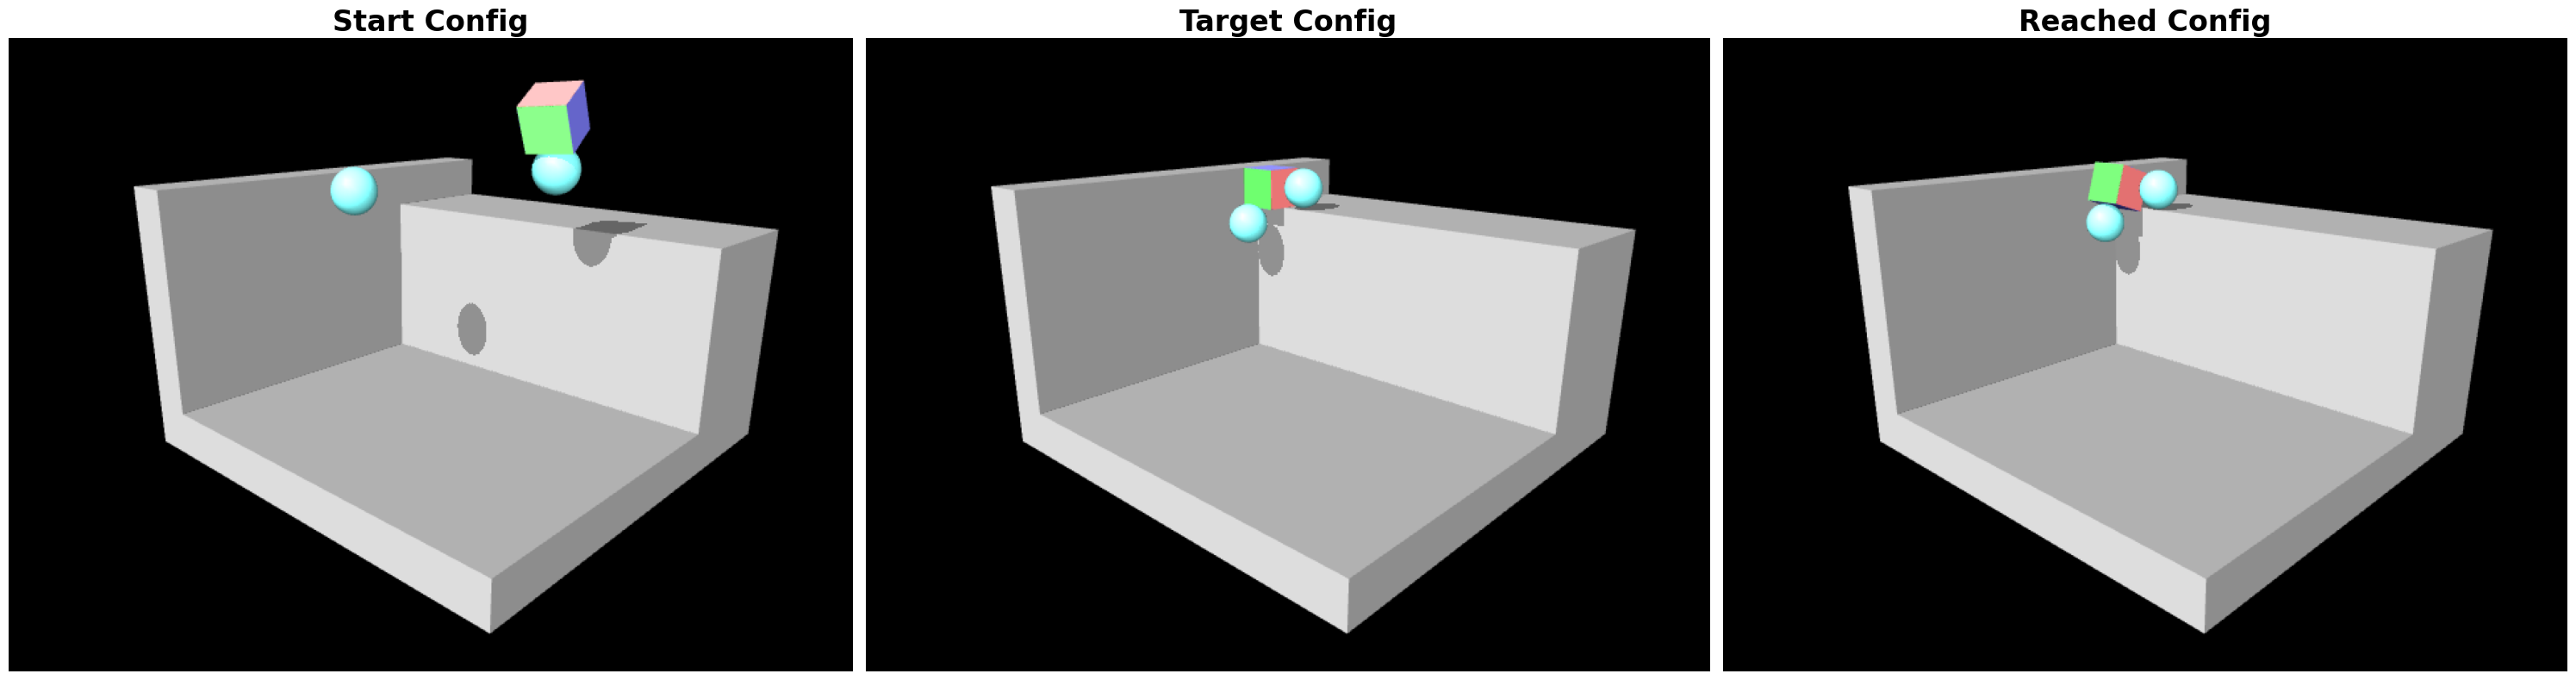

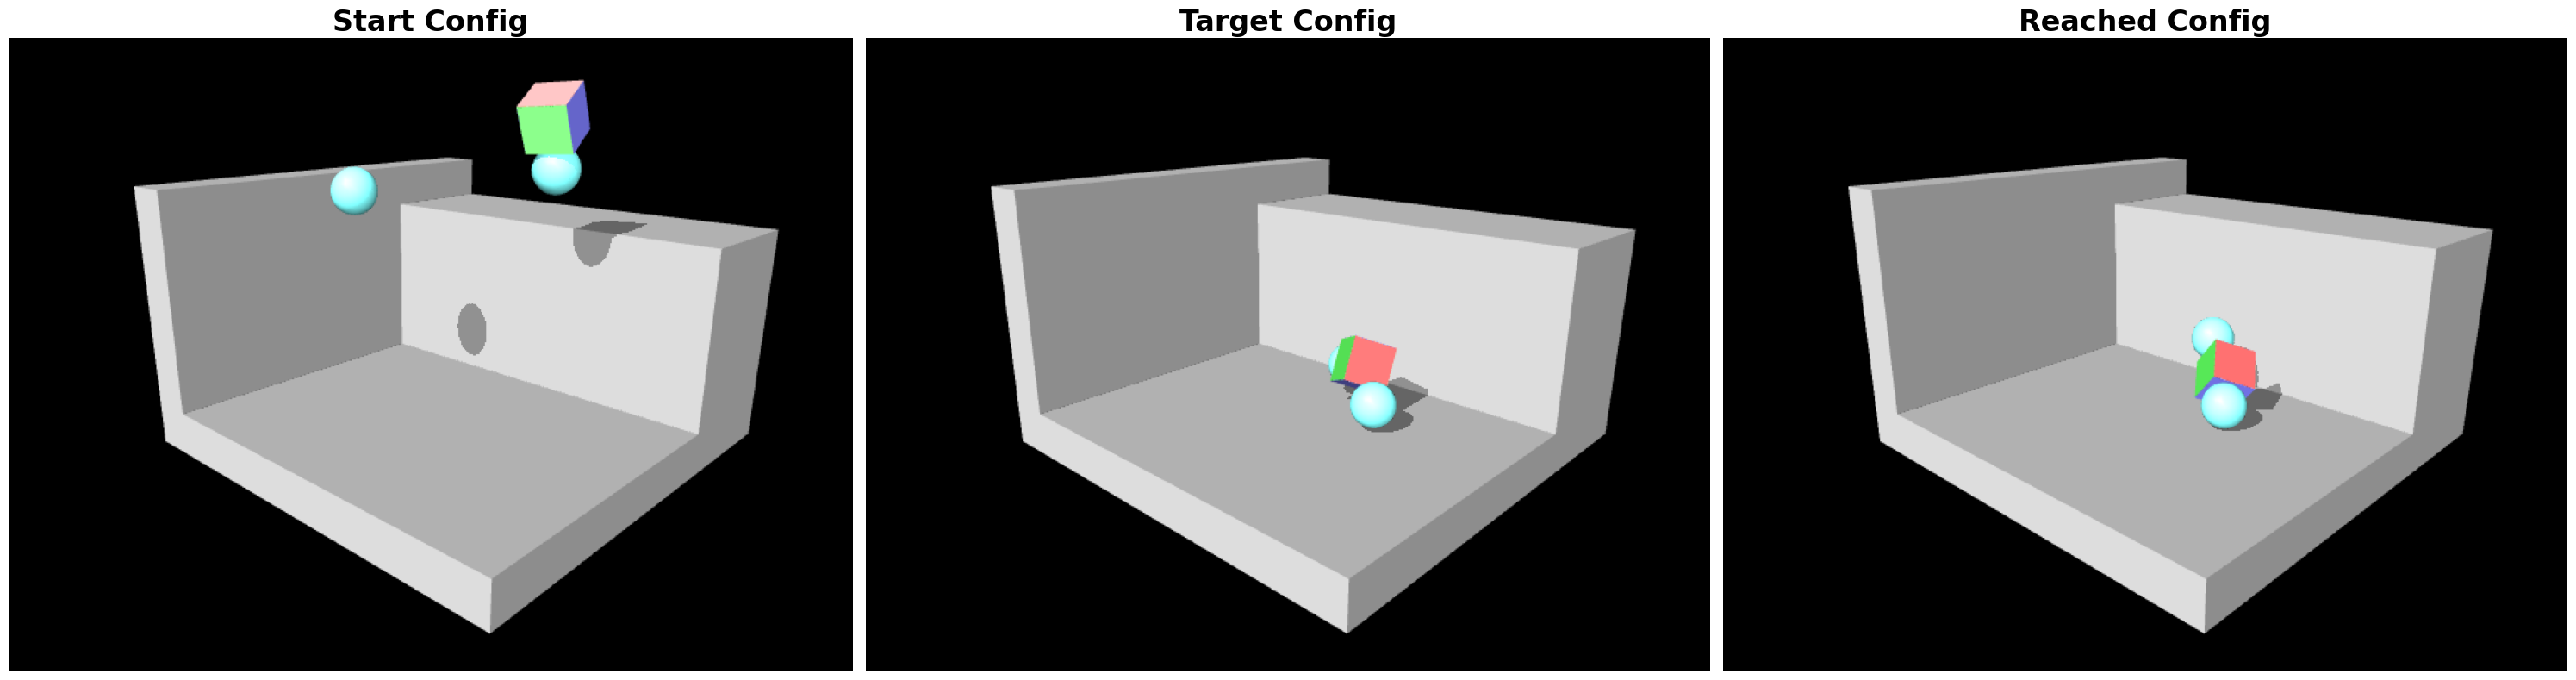

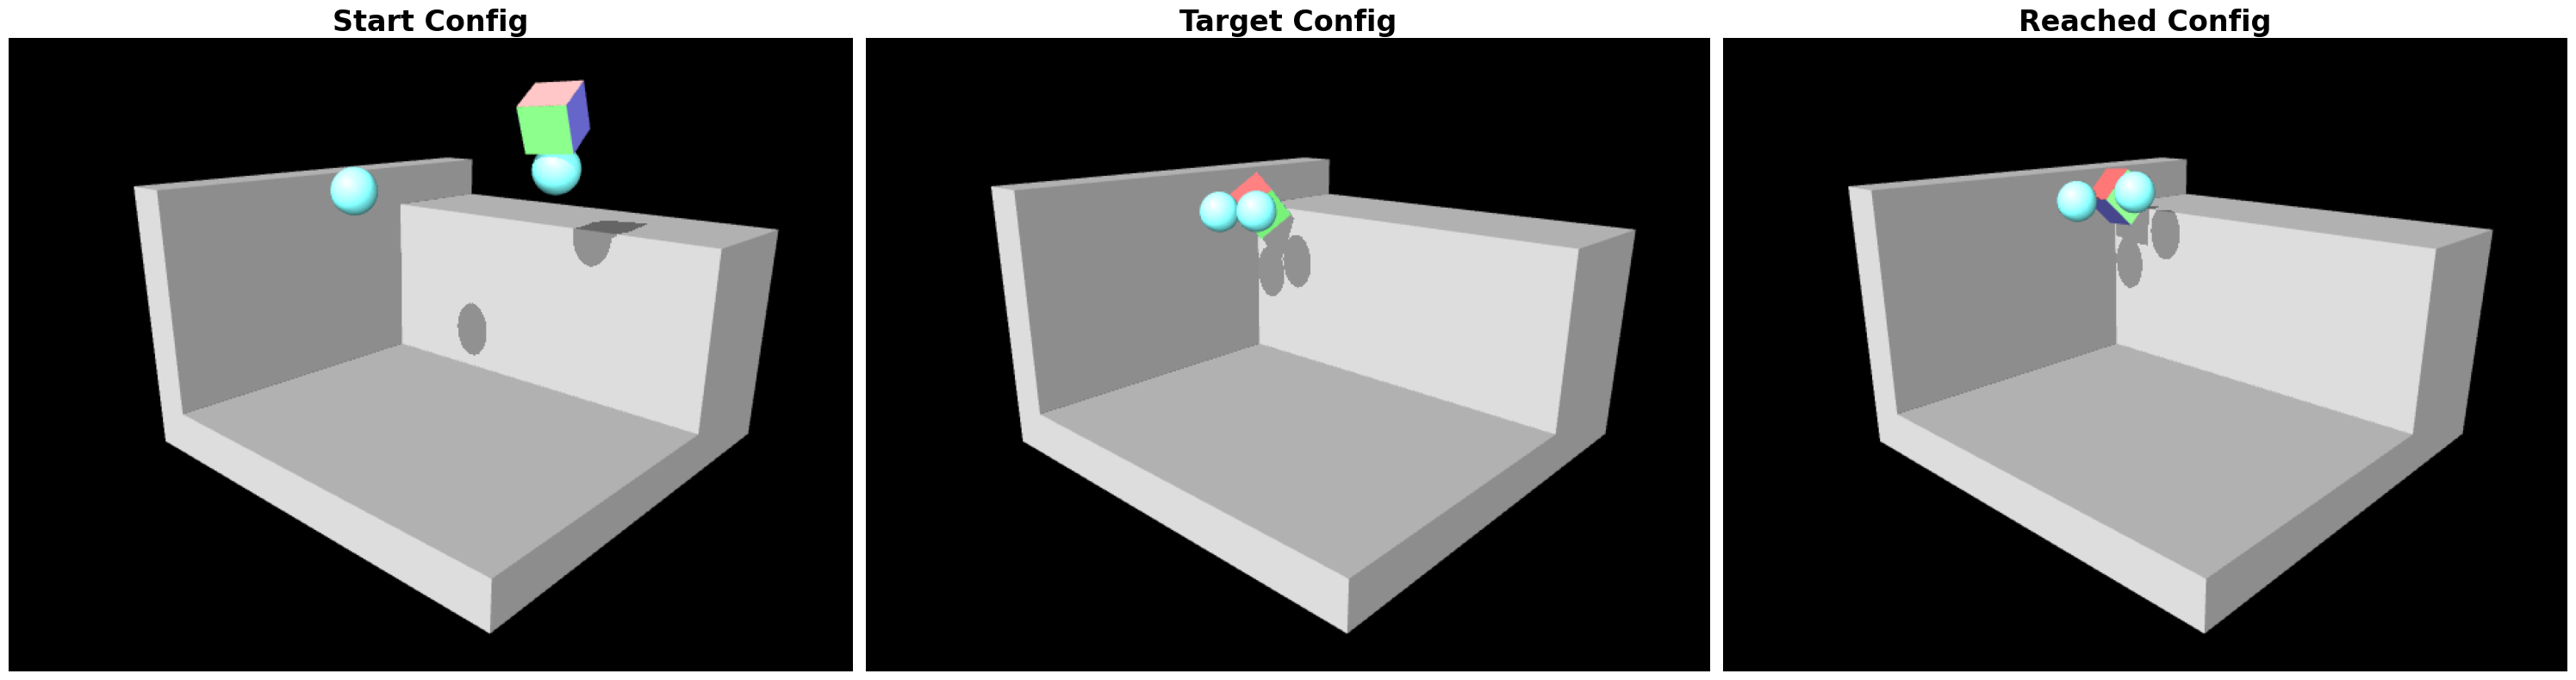

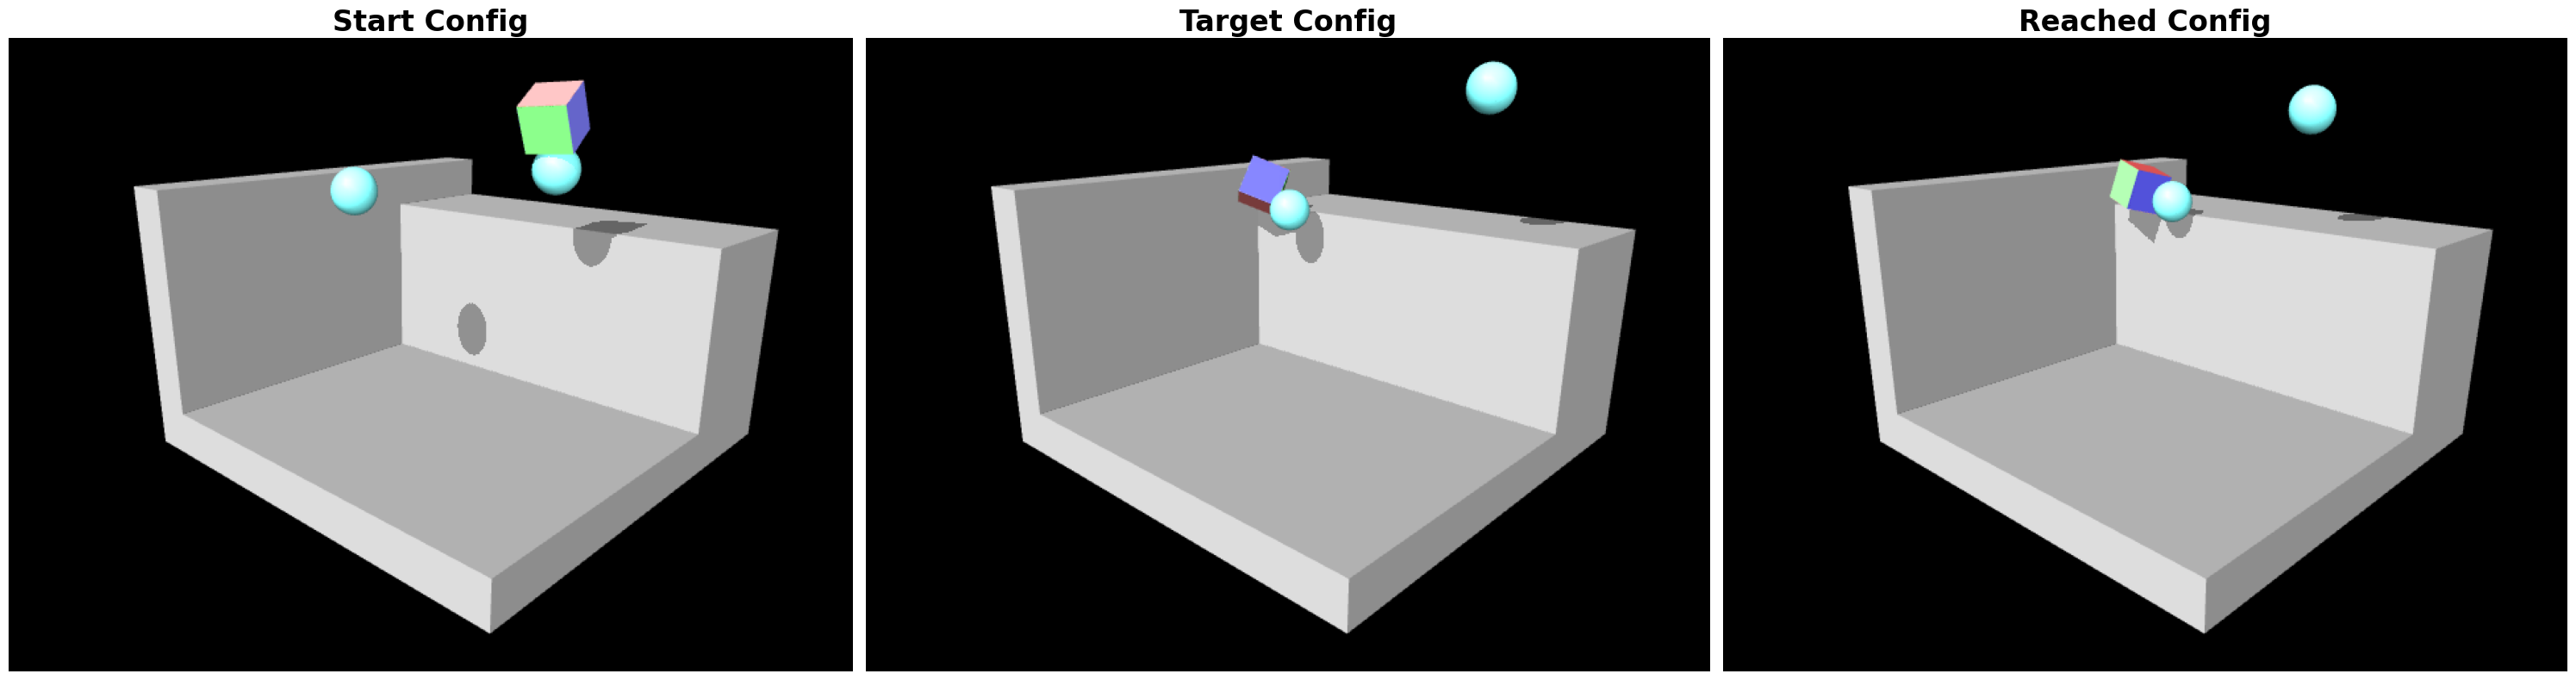

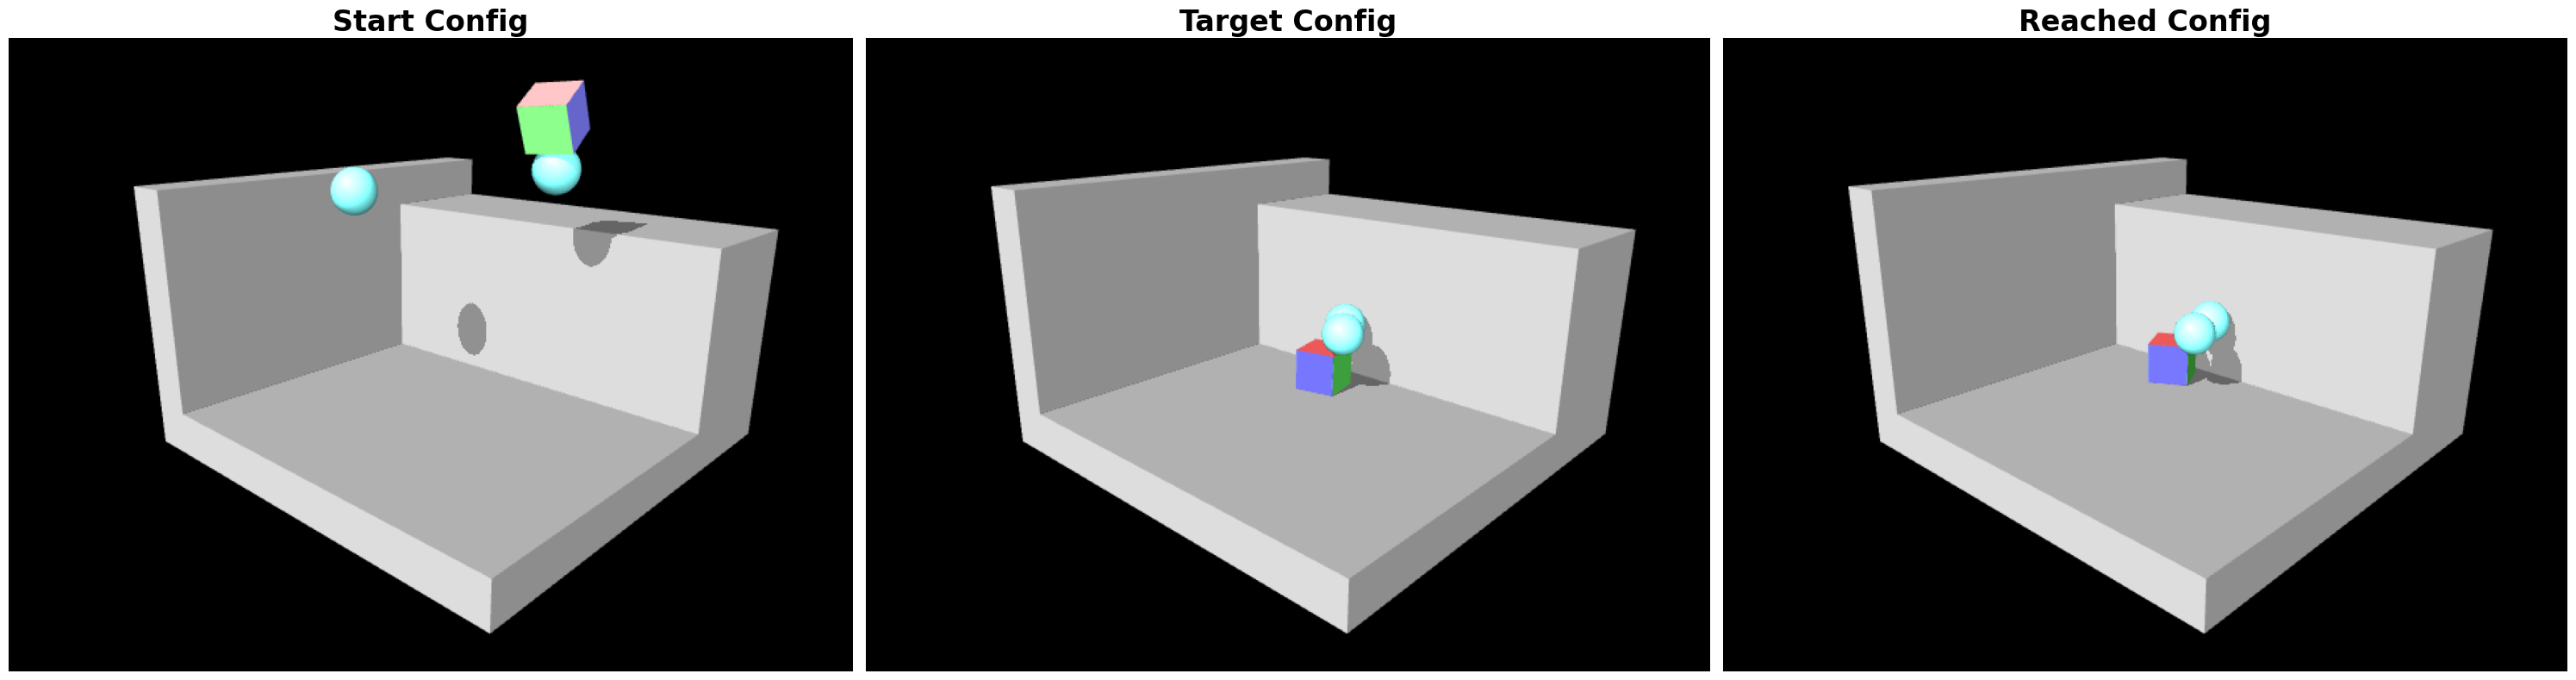

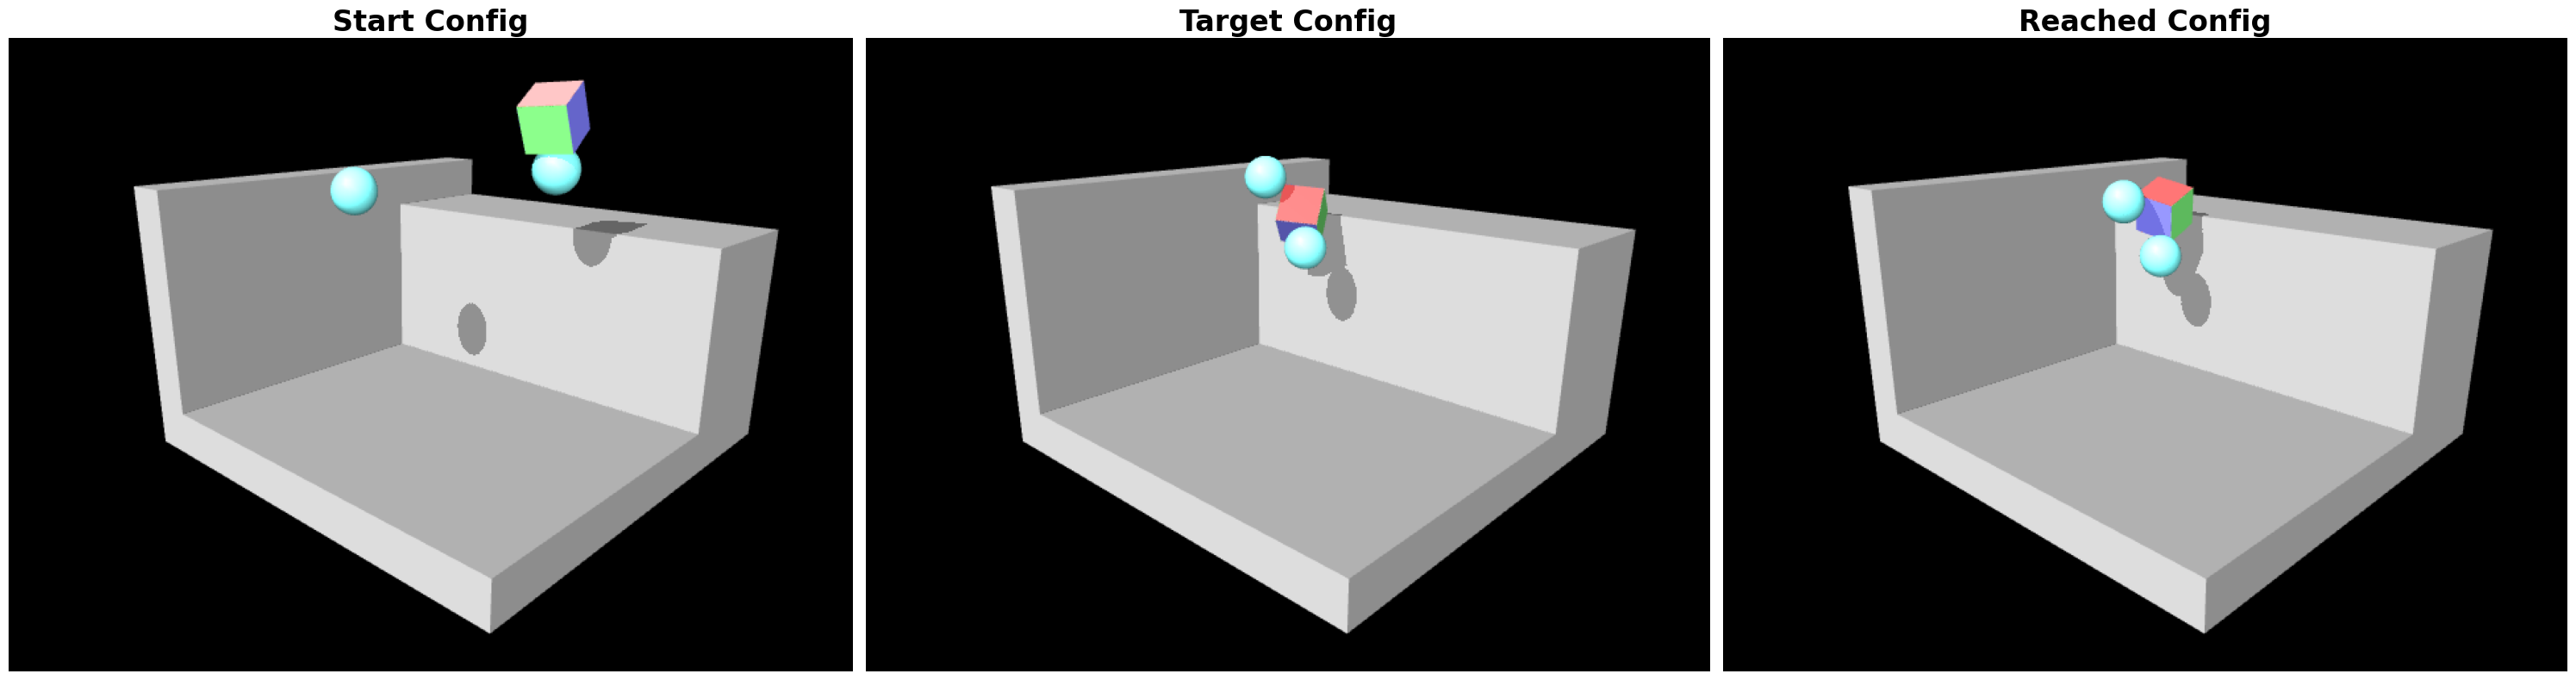

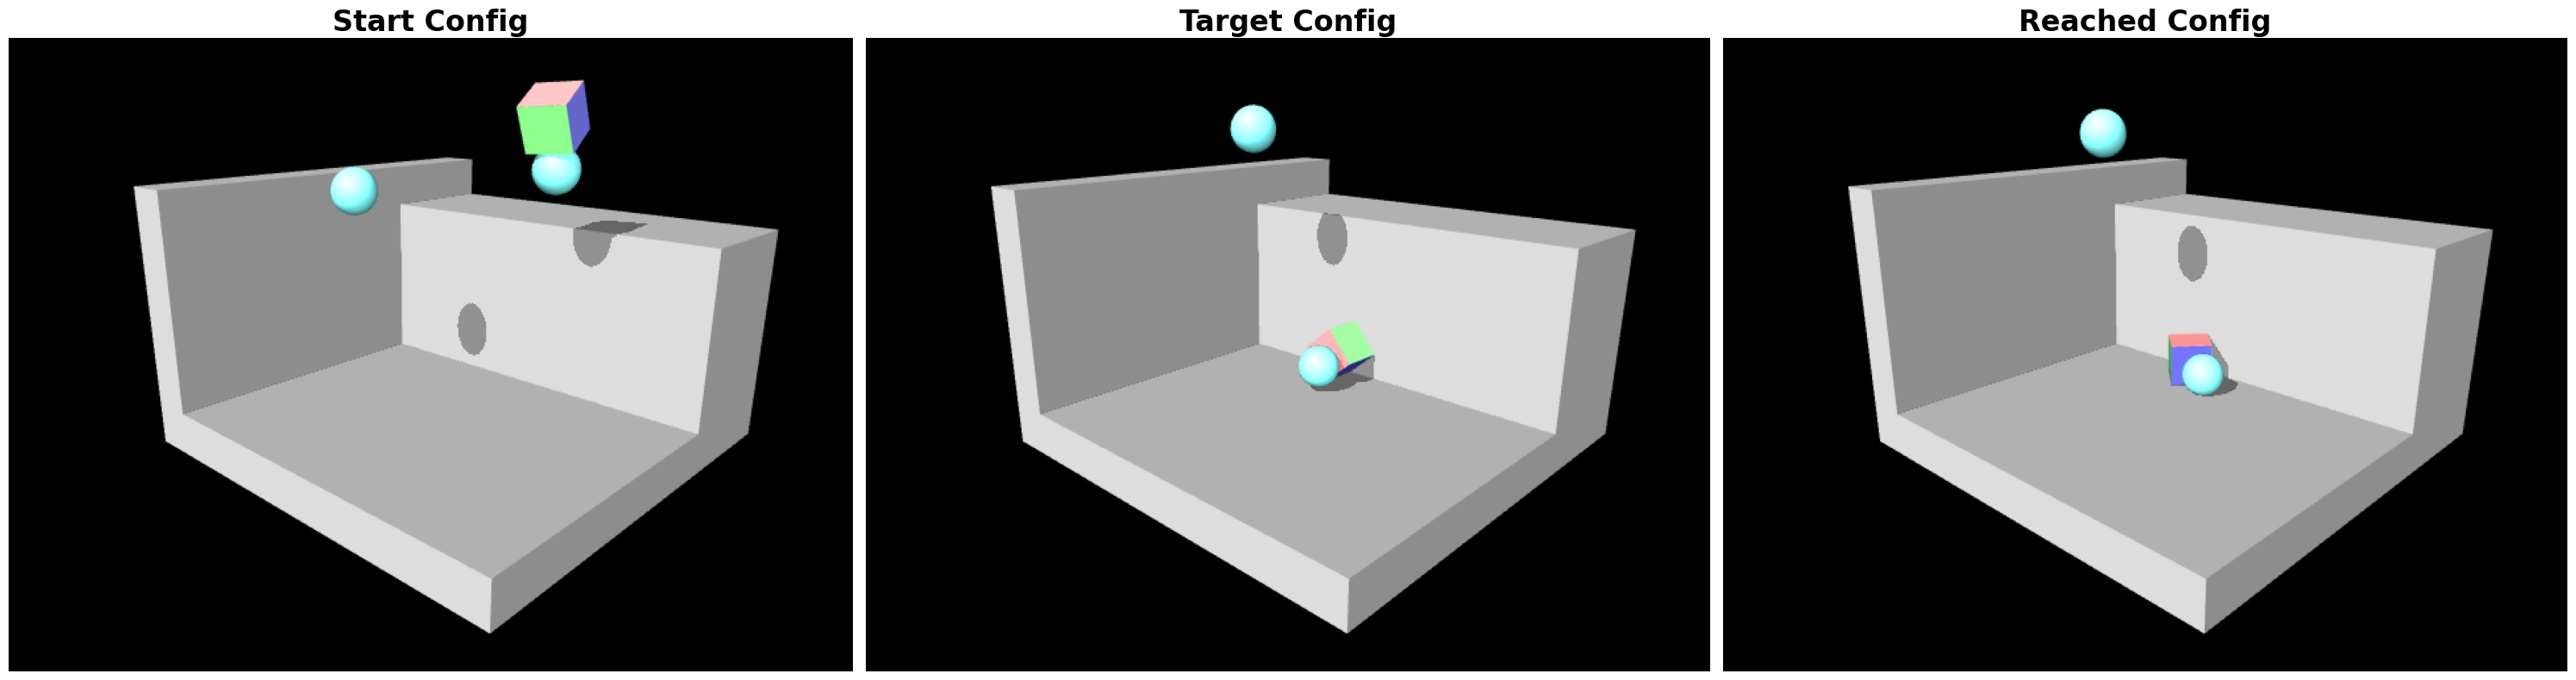

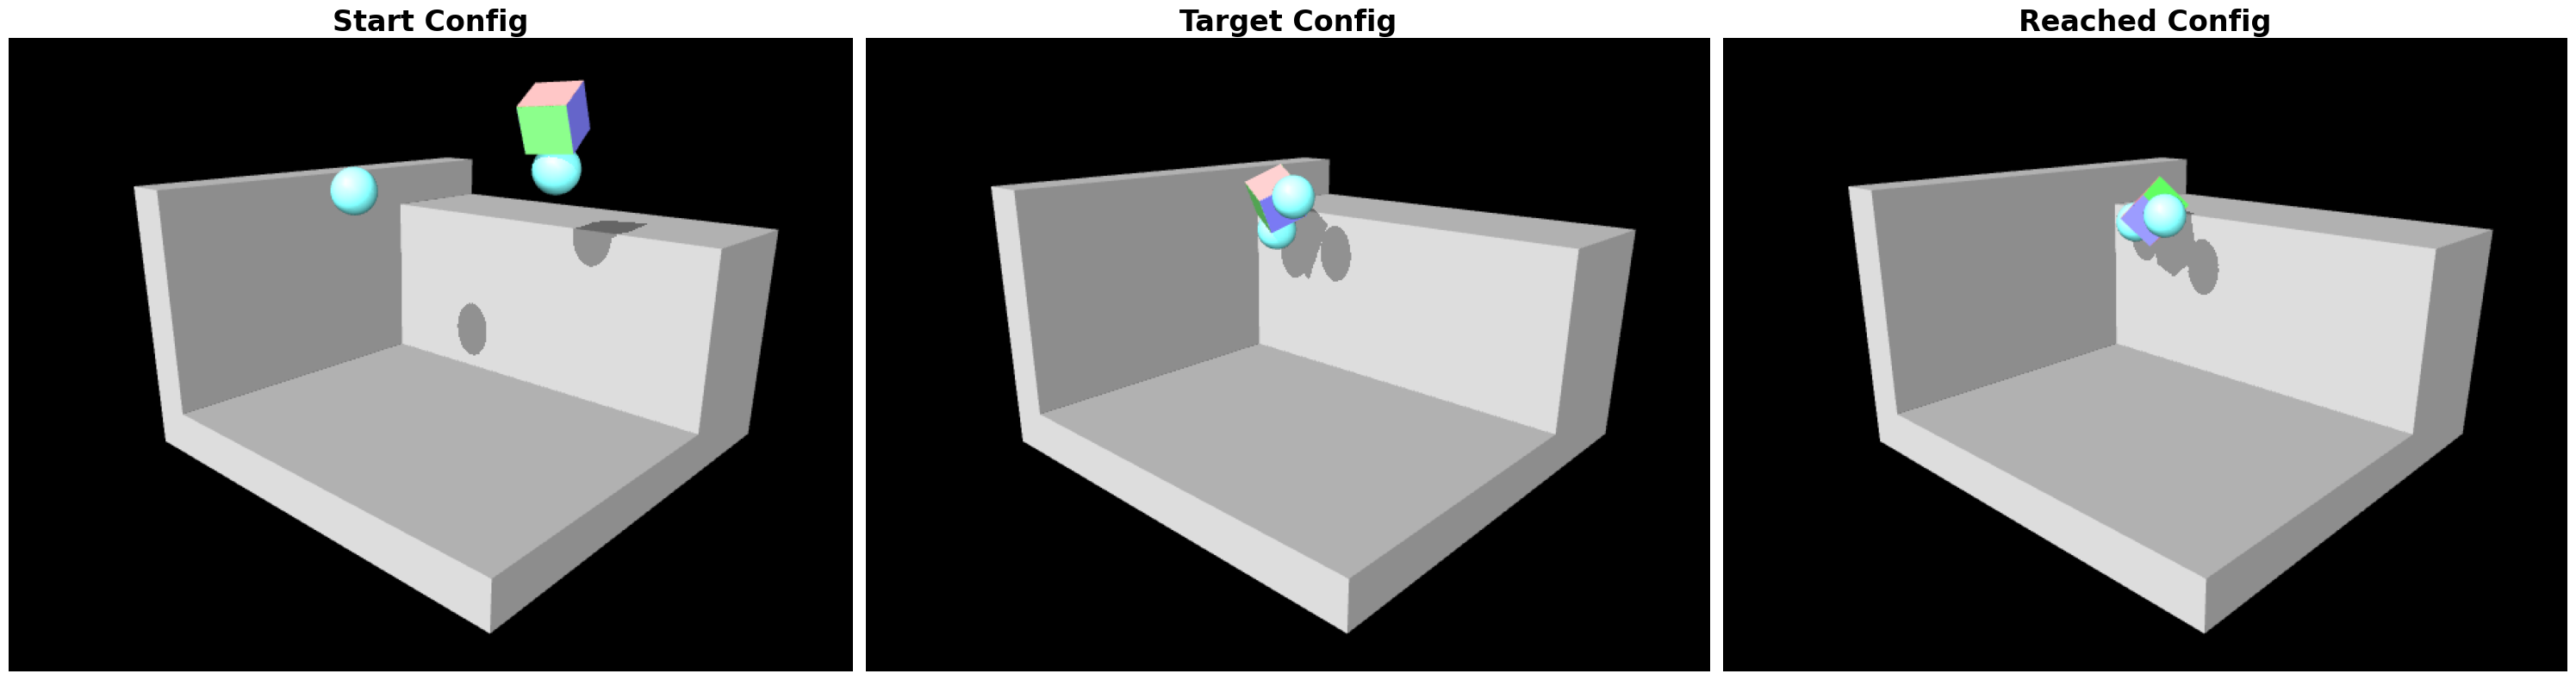

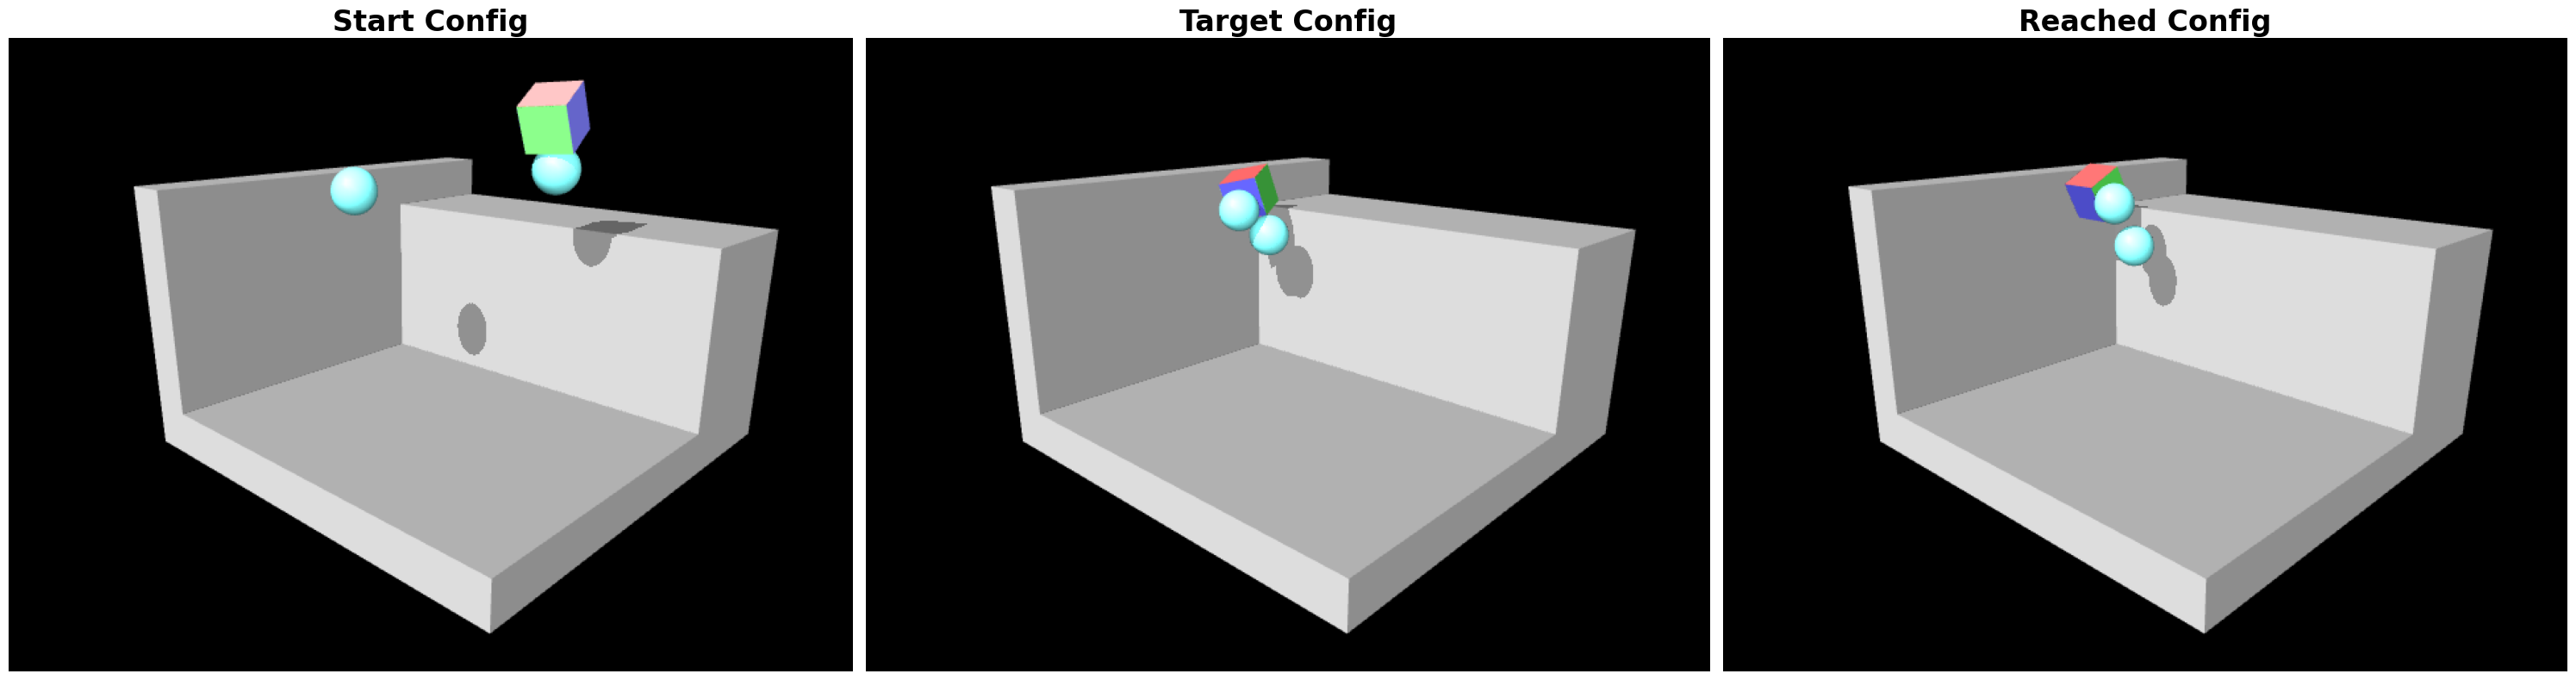

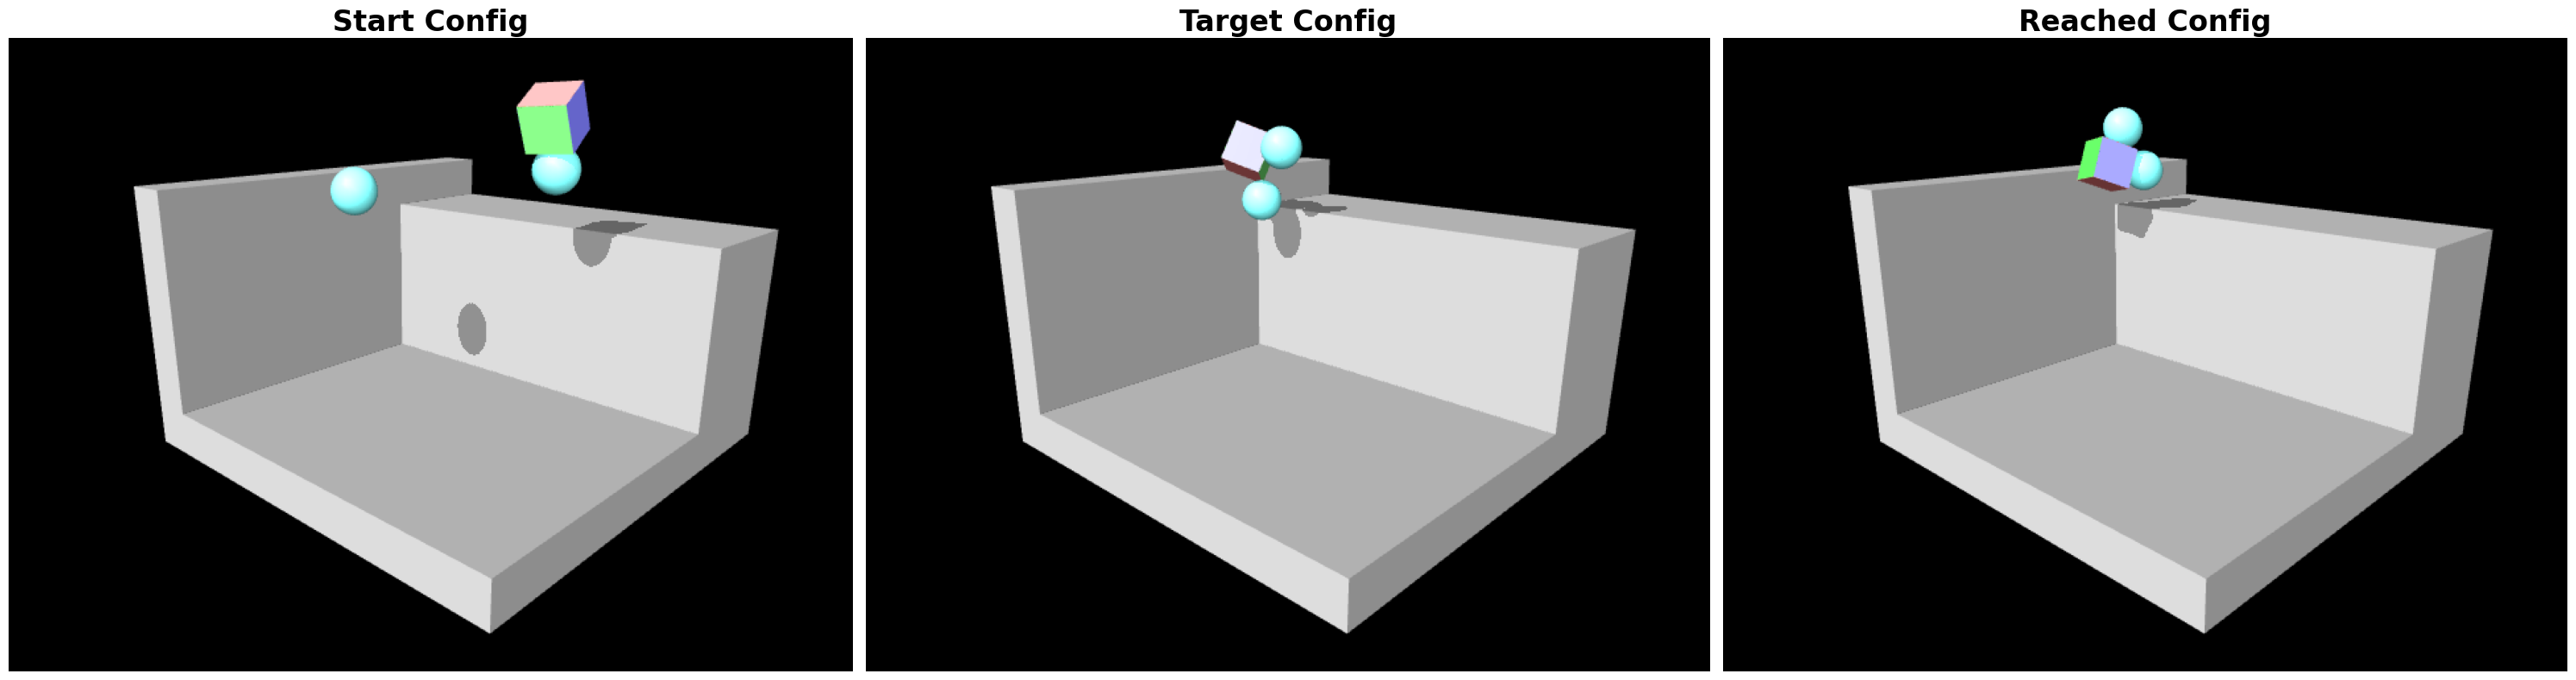

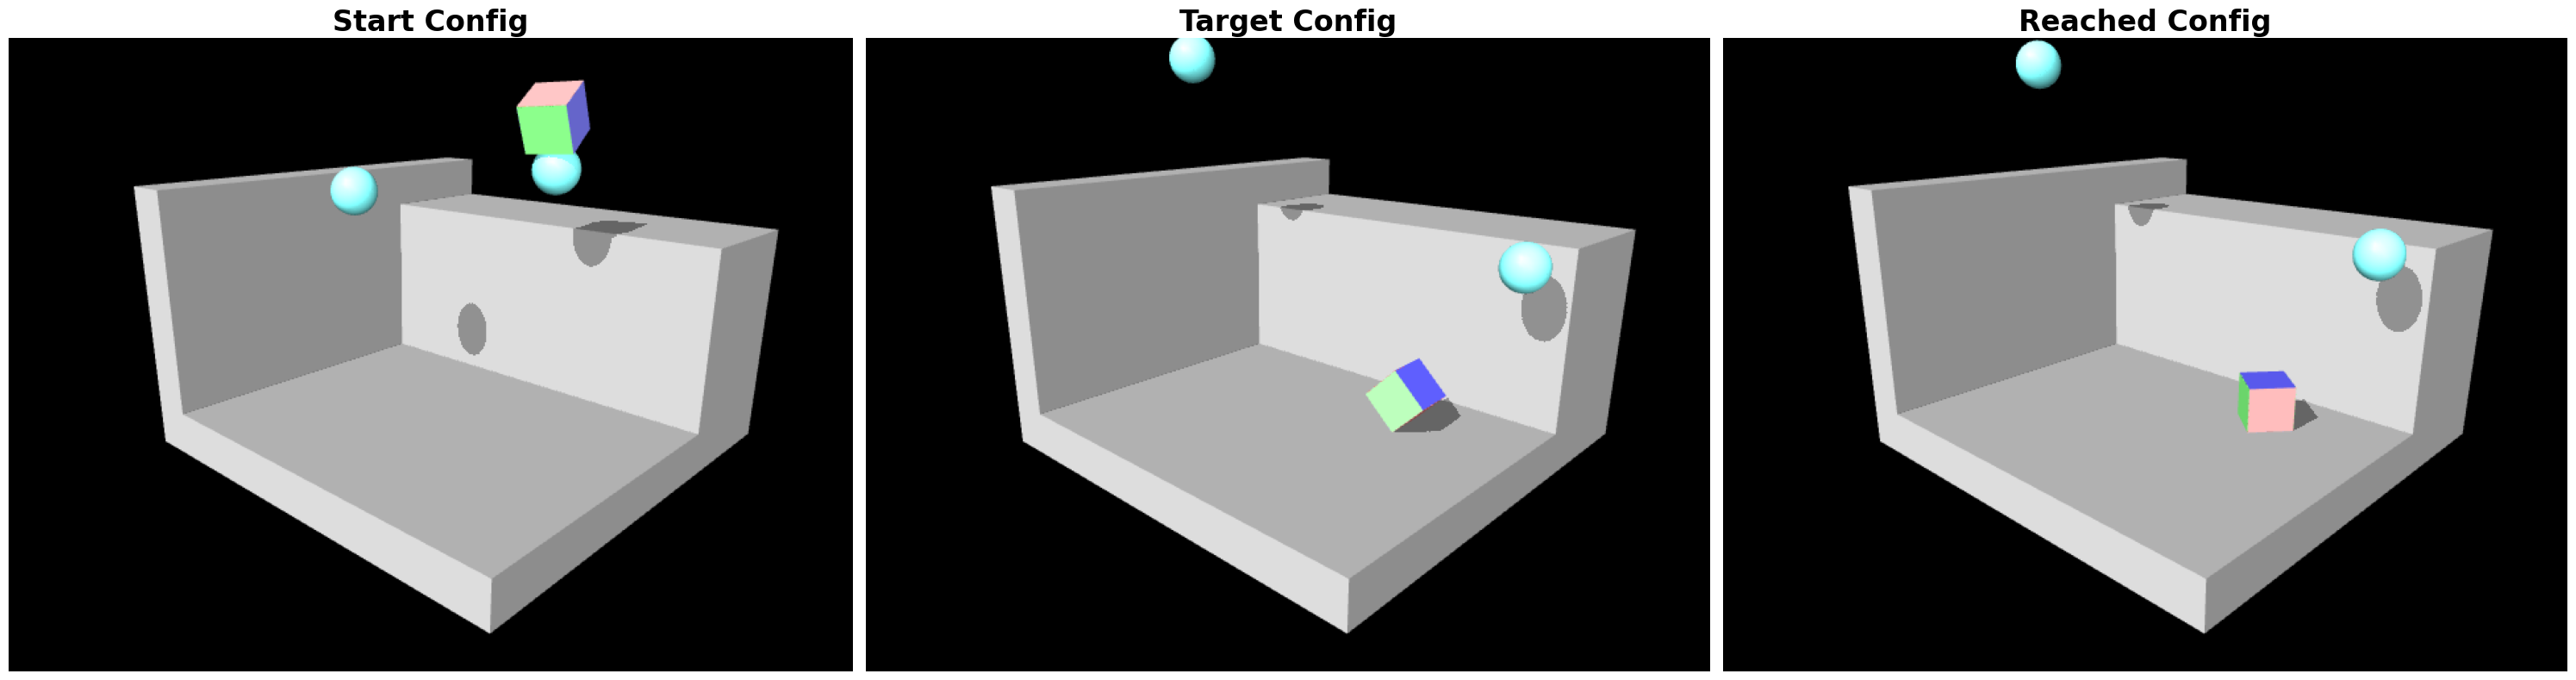

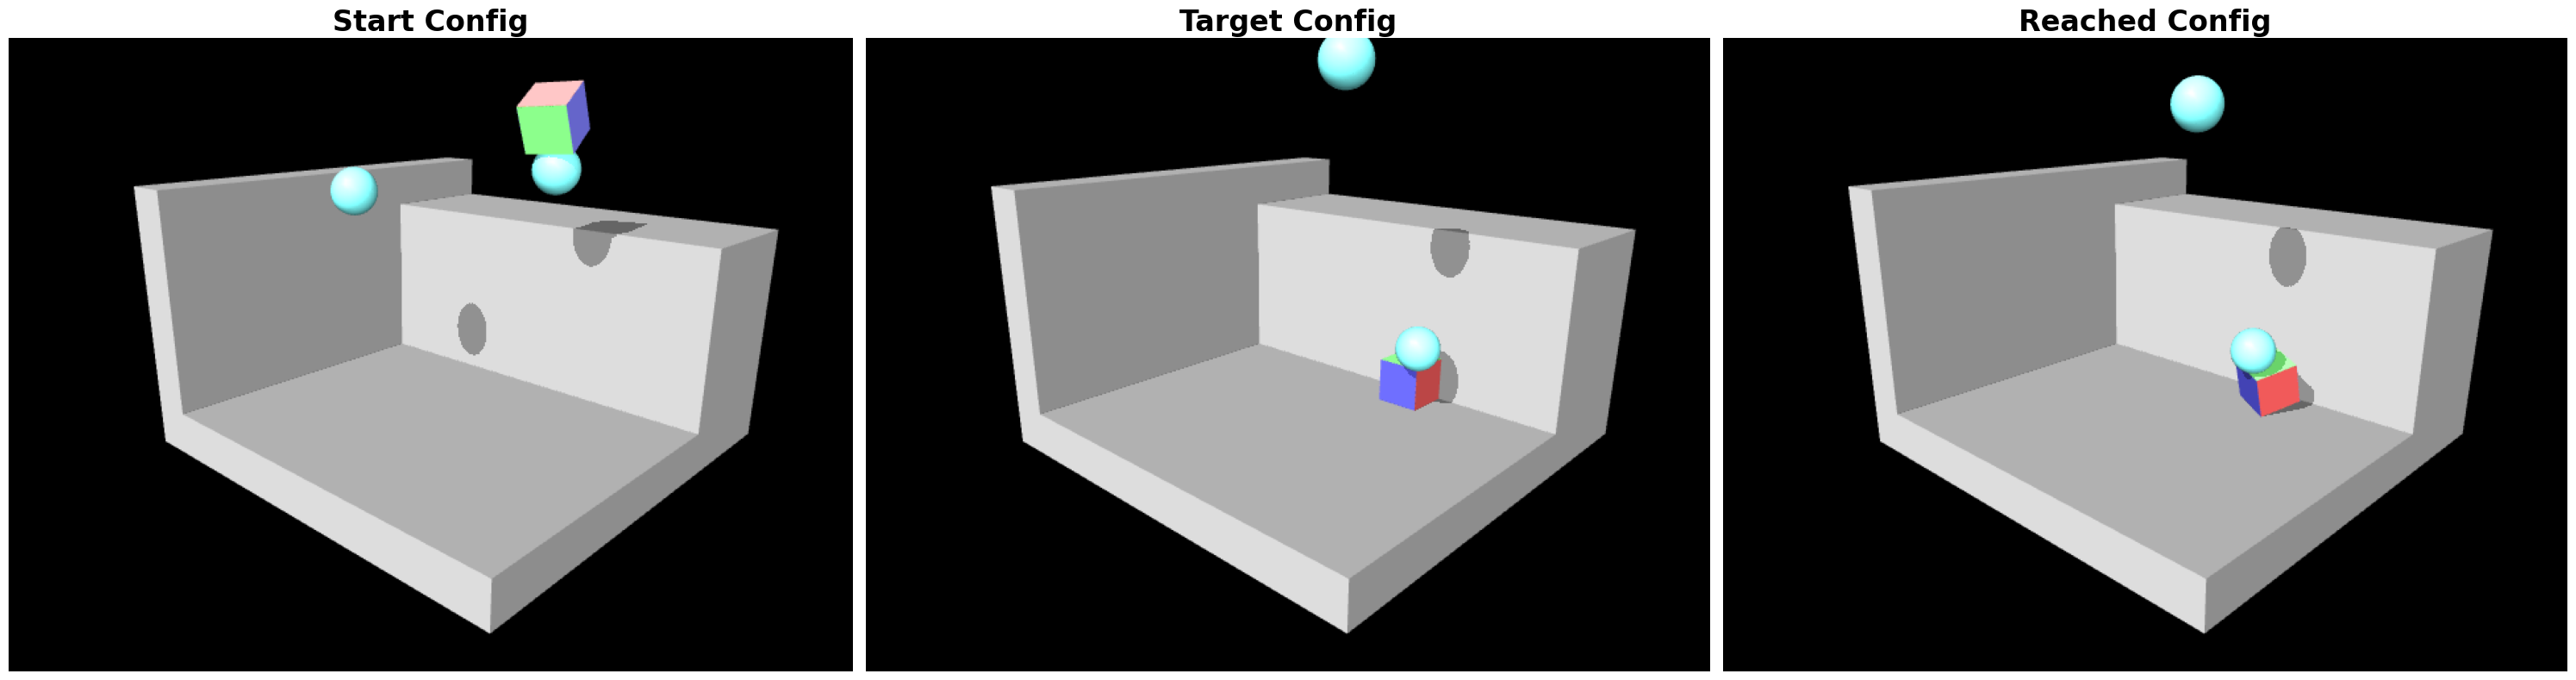

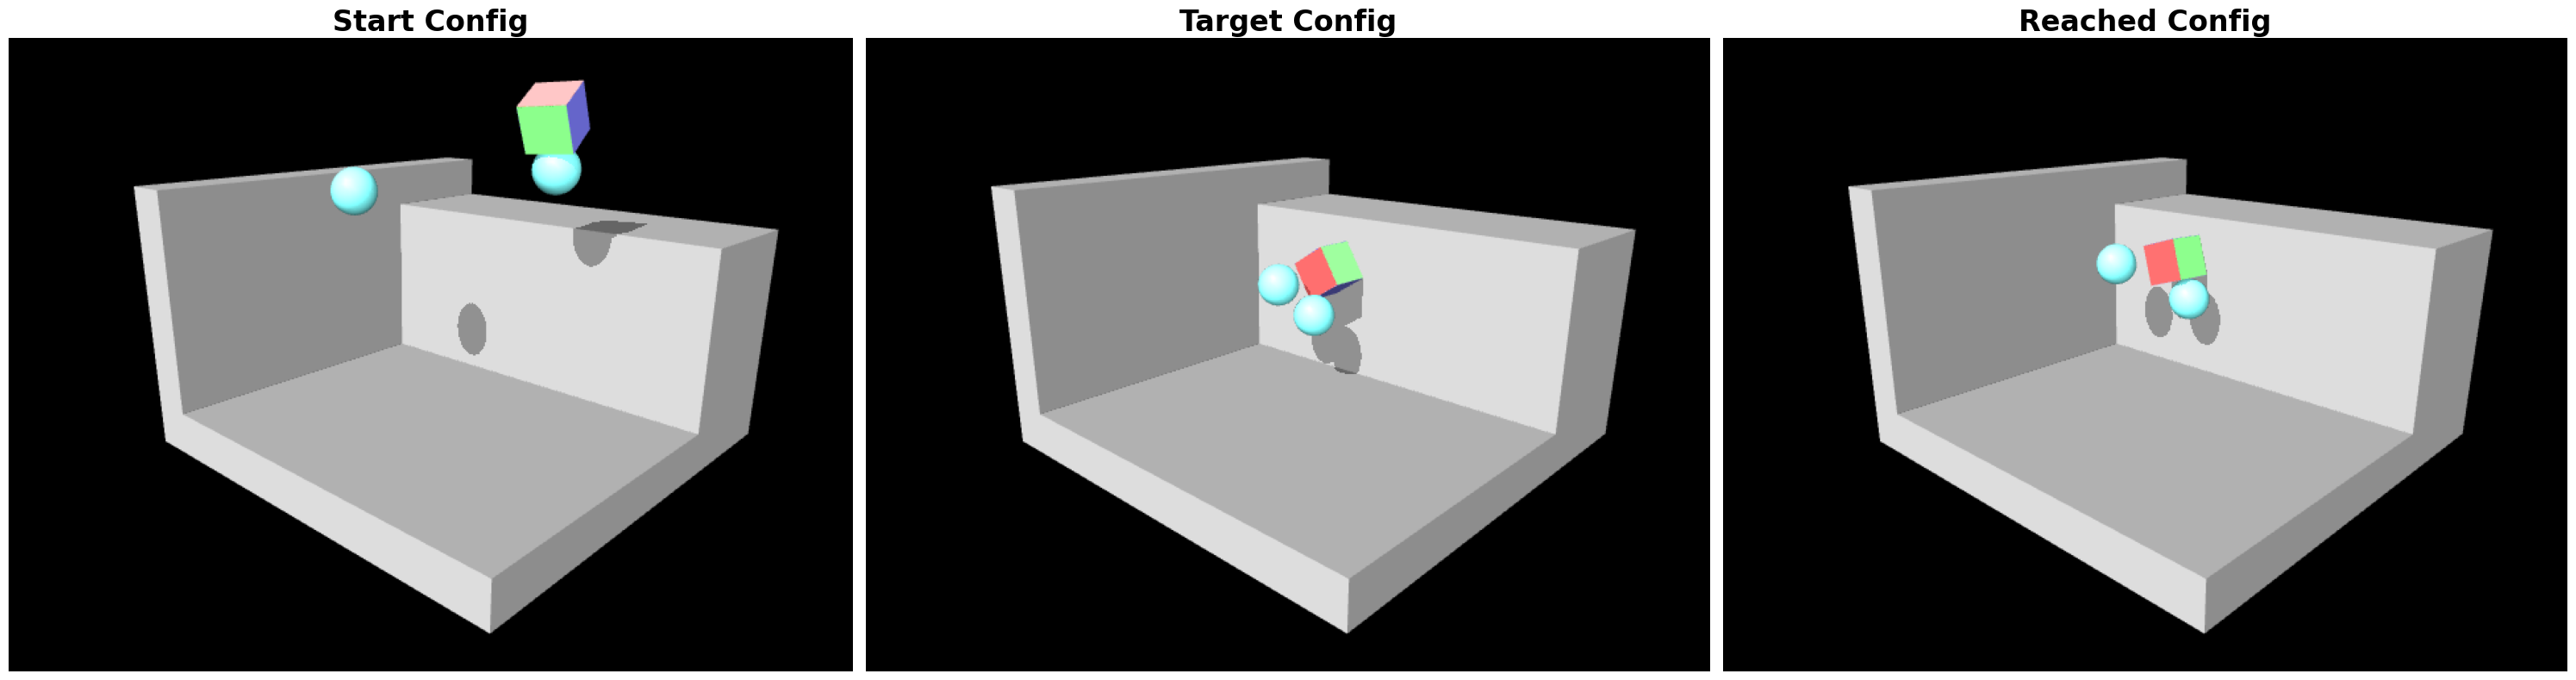

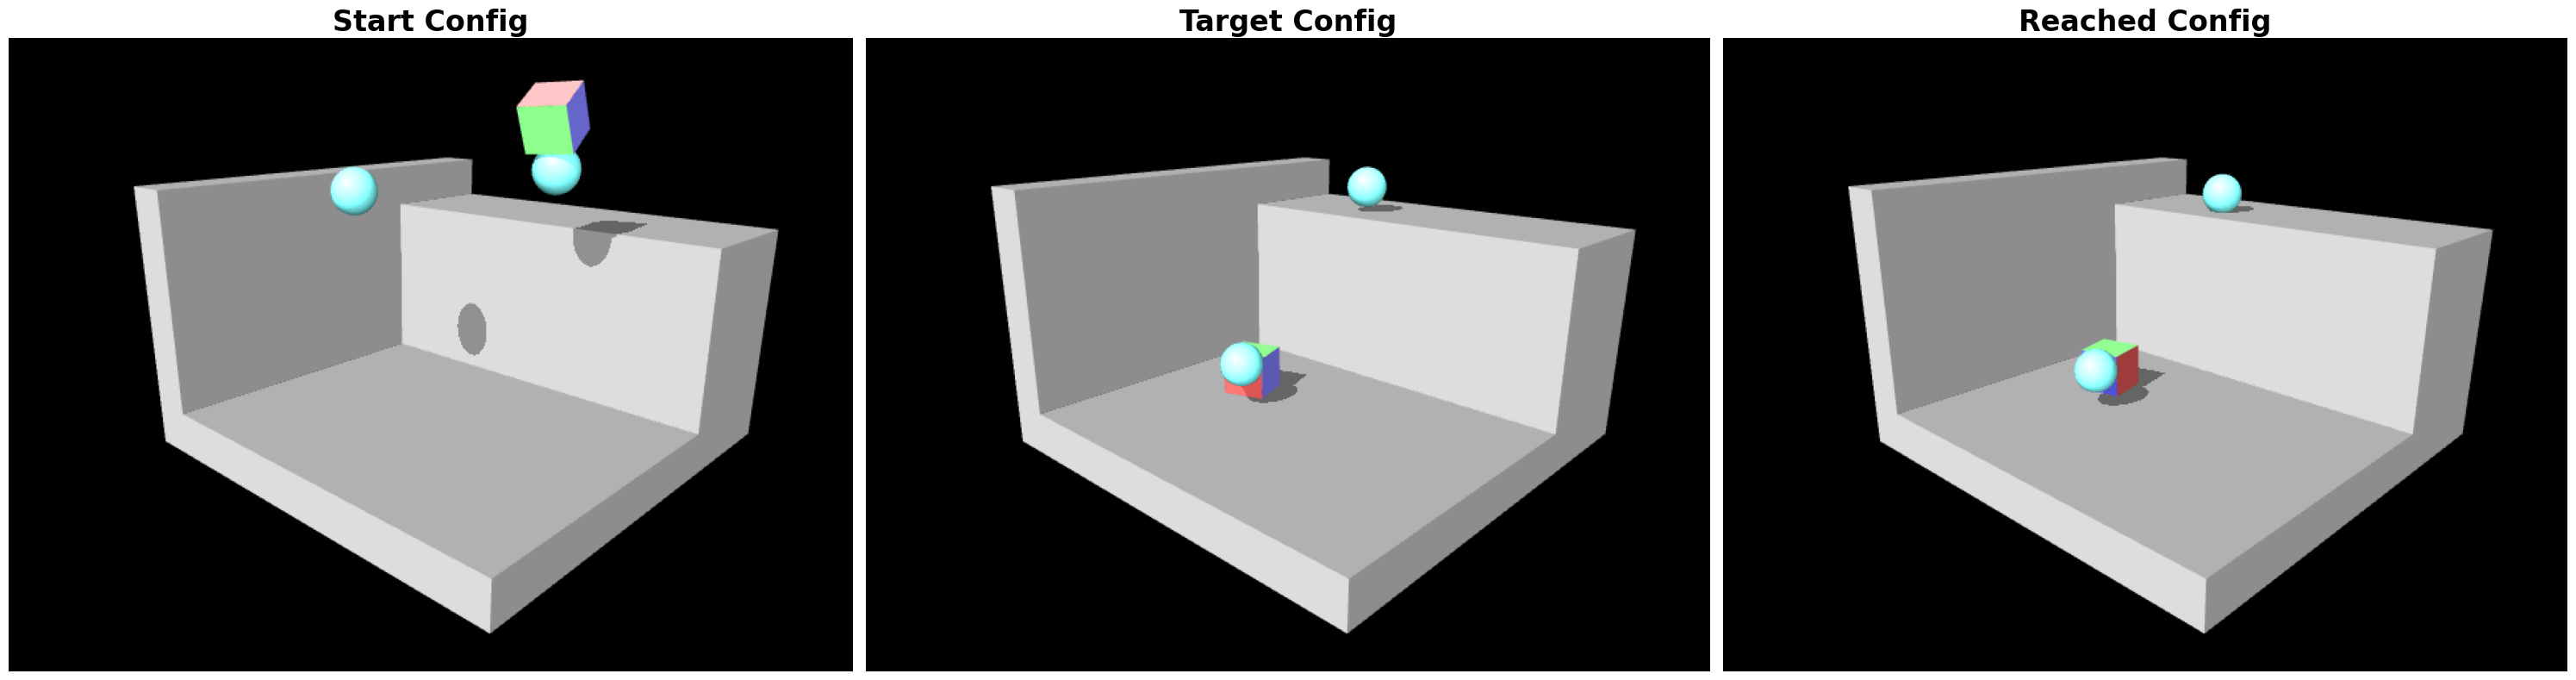

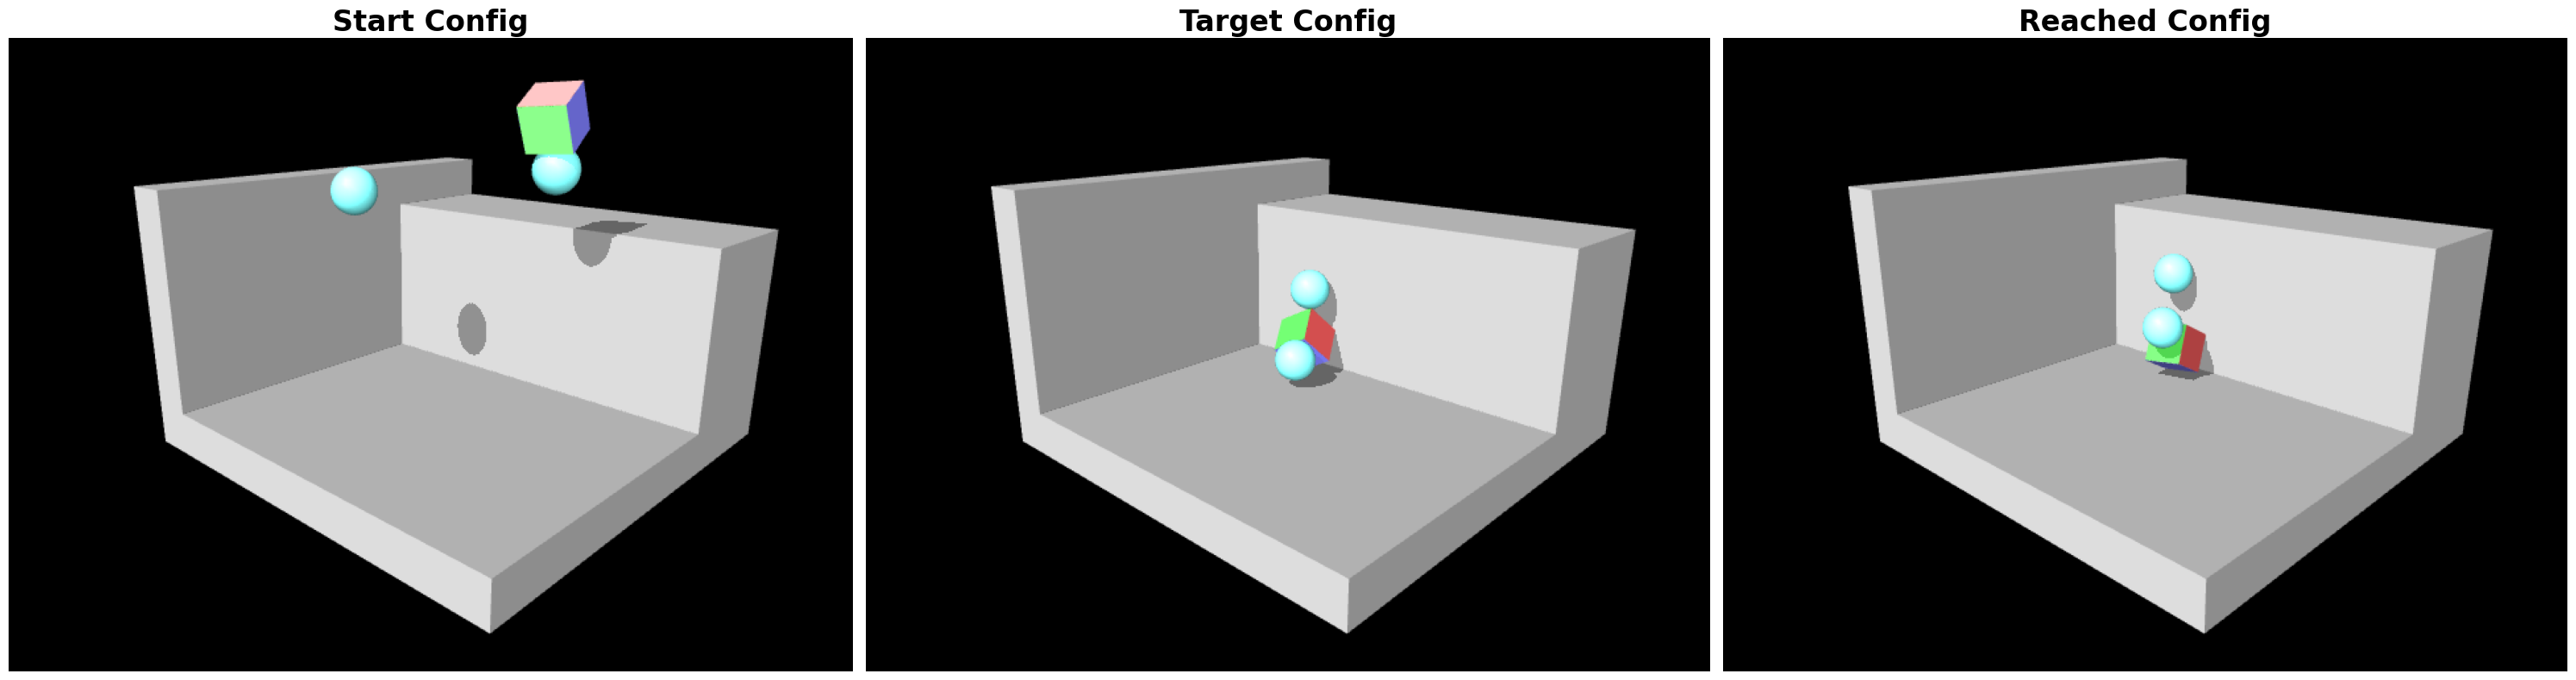

In [61]:
if path:
    for i, path_idx in enumerate(valid_path_idxs):
        path = top_paths[path_idx]
        start_idx = top_paths_start[path_idx]
        end_idx = top_paths_goal[path_idx]
        e_vec = trees[end_idx][0]["state"][1] - path[-1]["state"][1]

        print("---- Sampled Path Data ----")
        print("Target config ids: ", [n["target_config_idx"] for n in path])
        print("Start idx: ", start_idx)
        print("End idx: ", end_idx)
        print("Cost: ", top_costs[path_idx])
        print("Error vec: ", e_vec)
        print("Error vec (with mask): ", e_vec * q_mask)
        print("Sampled Path Length: ", len(path))

        start_state = trees[start_idx][0]["state"][1]
        target_state = trees[end_idx][0]["state"][1]
        sim = MjSim(
            mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
            joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False, use_spline_ref=sim_cfg.use_spline_ref
        )
        play_path(path, sim, start_state, target_state, tau_action=sim_cfg.tau_action, camera=cfg.RRT.sim.camera, reset_state=True, save_intro_as=f"paths/intro{i}.png", save_as=f"paths/path{i}.gif")


In [20]:
if path:
    fig, axes = plt.subplots(2, len(path), figsize=(60, 10))
    for i, node in enumerate(path):

        fig.suptitle("Sampled Configs During Trajectory", fontsize=48, fontweight="bold")

        sim.pushConfig(node["state"][1])
        im_state = sim.renderImg()

        axes[0, i].set_title(f"Node {i}", fontsize=32)
        axes[0, i].imshow(im_state)
        axes[0, i].axis("off")

        tci = node["target_config_idx"]
        axes[1, i].set_title(f"Sampled id {tci}", fontsize=32)
        axes[1, i].axis("off")
        if tci != -1:
            sim.pushConfig(trees[tci][0]["state"][1])
            im_target = sim.renderImg()
            
            if tci == end_idx:
                rect = patches.Rectangle(
                    (0, 0), 1, 1,
                    transform=axes[1, i].transAxes,
                    linewidth=10,
                    edgecolor="red",
                    facecolor="none"
                )
                axes[1, i].add_patch(rect)
        else:
            im_target = np.zeros_like(im_state)
        axes[1, i].imshow(im_target)
        
    plt.tight_layout()
    plt.show()

## Bi-directional analysis

In [37]:
bidir = cfg.RRT.bidirectional and cfg.RRT.start_idx != -1 and cfg.RRT.start_idx != -1
if bidir:
    si = cfg.RRT.start_idx
    ei = cfg.RRT.end_idx
    bi_tree_tolerance = cfg.RRT.bi_tree_tolerance

    bi_tree_dataset = os.path.join(dataset, "bi_trees")
    bi_trees, bi_tree_count, bi_total_nodes_count = load_trees(bi_tree_dataset)

    print(f"Starting bi-directional analysis for trees with sizes {len(trees[si])} and {len(bi_trees[ei])}")

    # Find connections to target without the bi-tree
    found_direct_nodes_ids = []
    for id, node in enumerate(trees[si]):
        cost_to_target = cost_computation(node, trees[ei][0], q_mask, cost_max_method)
        if cost_to_target <= ERROR_THRESH:
            found_direct_nodes_ids.append(id)

    # Find connections using the bi-tree
    found_bi_nodes_ids = []
    min_cost_between_trees = 1e6
    for id, node in tqdm(enumerate(trees[si])):
        for bi_id, bi_node in enumerate(bi_trees[ei]):
            
            cost_to_target = cost_computation(node, bi_node, q_mask, cost_max_method)
            if cost_to_target <= bi_tree_tolerance:
                found_bi_nodes_ids.append((id, bi_id))
            
            if min_cost_between_trees > cost_to_target:
                min_cost_between_trees = cost_to_target

    print(f"------ Bi-Tree status for path from config {si} to {ei} ------")
    print(f"Node count in bi-tree: {len(bi_trees[ei])}")
    print(f"Found paths without bi-tree: {len(found_direct_nodes_ids)}")
    print(f"Found paths with bi-tree: {len(found_bi_nodes_ids)}")
    print(f"Minimum cost between trees: {min_cost_between_trees}")

In [38]:
if bidir and found_bi_nodes_ids:
    # Build full trajectory
    connection_idx = np.random.randint(0, len(found_bi_nodes_ids))
    id = found_bi_nodes_ids[connection_idx][0]
    bi_id = found_bi_nodes_ids[connection_idx][1]
    path_to = build_path(trees[si], id)
    path_from = build_path(bi_trees[ei], bi_id, reverse=False)
    full_path = path_to + path_from
    print(f"Percentage forward tree: {len(path_to)/len(full_path)*100:.2f} ({len(path_to)}/{len(full_path)})")

    # Play trajectory
    start_state = trees[si][0]["state"][1]
    target_state = trees[ei][0]["state"][1]
    sim = MjSim(
        mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
        joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False
    )
    play_path(full_path, sim, start_state, target_state, tau_action=sim_cfg.tau_action,
              camera=cfg.RRT.sim.camera, save_as="bi_path.gif", reset_state=False)
    
    # TODO: Glue trajectory nodes with BBO